#Starter

# INSTALL LIBRARY

In [1]:
!pip install contextily
!pip install mgwr
!pip install linearmodels
!pip install mapclassify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.9/389.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.7/286.7 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 78.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependen

# IMPORT LIBRARY

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from mgwr.gwr import GWR

from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import numpy.linalg as la
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [3]:
# Load Panel Dataset
datas = pd.read_excel(
    "/kaggle/input/data-gwpr/22052025 Data Gula (tahun kedua)  inflasi.xlsx", sheet_name='DATA'
)
# datas = datas.sort_values(by=['Year','Month','Province'])
# datas['YearMonth'] = pd.to_numeric(datas['Year'].apply('{:0>4}'.format) + datas['Month'].apply('{:0>2}'.format))
# S_price = MinMaxScaler()
# S_production = MinMaxScaler()
# S_importation = MinMaxScaler()
# S_demand = MinMaxScaler()

# datas['Price'] = S_price.fit_transform(datas['Price'].values.reshape(-1,1))
# datas['Production'] = S_price.fit_transform(datas['Production'].values.reshape(-1,1))
# datas['Importation'] = S_price.fit_transform(datas['Importation'].values.reshape(-1,1))
# datas['Demand'] = S_price.fit_transform(datas['Demand'].values.reshape(-1,1))

# datas.head()
datas = datas.drop(['No','Latitude', 'Longitude', 'Inflation', 'Economy Growth (%)'],axis=1)
datas['Province'] = datas['Province'].replace({
    'Bangka Belitung': 'Bangka-Belitung',
    'Jakarta': 'Jakarta Raya'
})

datas

Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  
0        4811100                  0  
1        4811100                  0  
2        4811100                  0  
3        4811100                  0  
4        4811100                  0  
...          ...                ...  
4075     4418600                  0  
4076     4418600                  0  
4077     4418600                  0  
4078     4418600                  0  
4079     4418600                  1  

[4080 rows x 10 columns]

# EXPLORATORY DATA ANALYSIS

## 1) NAN VALUES

In [4]:
datas.isna().sum()

Province             0
Year                 0
Month                0
Production           1
Importation          0
Demand               1
Supply               1
Price                1
Population           0
Religious Holiday    0
dtype: int64

## 2) SUPPLY VS DEMAND (RATA - RATA 10 TAHUN TERAKHIR)

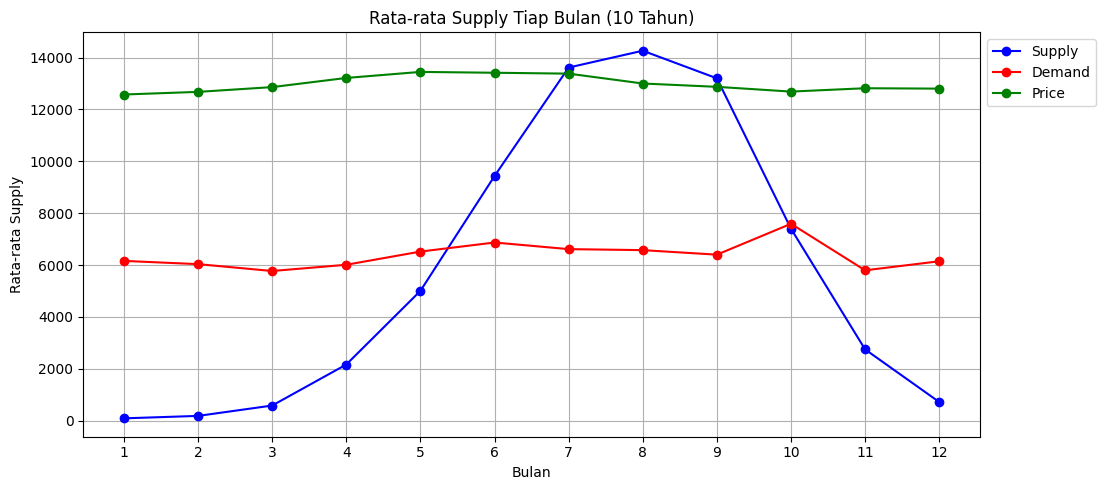

In [5]:
avg_supply_per_month = datas.groupby("Month")["Supply"].mean()
avg_demand_per_month = datas.groupby("Month")["Demand"].mean()
avg_price_per_month = datas.groupby("Month")["Price"].mean()
# Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_supply_per_month.index, avg_supply_per_month.values, marker='o', linestyle='-', color='b',label='Supply')
plt.plot(avg_demand_per_month.index, avg_demand_per_month.values, marker='o', linestyle='-', color='r',label='Demand')
plt.plot(avg_price_per_month.index, avg_price_per_month.values, marker='o', linestyle='-', color='g',label='Price')
plt.title("Rata-rata Supply Tiap Bulan (10 Tahun)")
plt.xlabel("Bulan")
plt.ylabel("Rata-rata Supply")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## 3) IMPORTATION VS PRODUCTION VS DEMAND (RATA RATA PER TAHUN)

In [6]:
datas['Year'].unique()
jumlah_per_tahun =datas['Year'].value_counts().sort_index()

print(jumlah_per_tahun)

Year
2013    408
2014    408
2015    408
2016    408
2017    408
2018    408
2019    408
2020    408
2021    408
2022    408
Name: count, dtype: int64


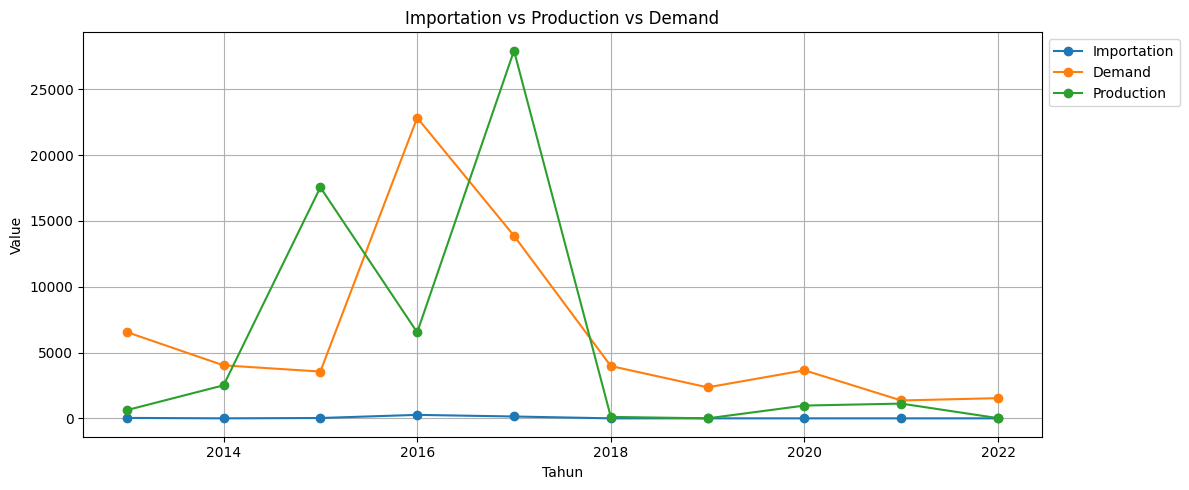

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Misalnya kamu sudah punya DataFrame `datas` berisi 4080 baris (10 tahun × 408)
# Buat list tahun berulang sebanyak 408 kali per tahun
years = list(range(2013, 2023))  # 2013–2022
datas['Year'] = [year for year in years for _ in range(408)]

# Hitung rata-rata per tahun
grouped = datas.groupby('Year')[['Importation', 'Demand', 'Production']].mean()

# Plot rata-rata tahunan
plt.figure(figsize=(12, 5))

plt.plot(grouped.index, grouped['Importation'], marker='o', label='Importation')
plt.plot(grouped.index, grouped['Demand'], marker='o', label='Demand')
plt.plot(grouped.index, grouped['Production'], marker='o', label='Production')
plt.xlabel("Tahun")
plt.ylabel("Value")
plt.title("Importation vs Production vs Demand")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## 5) PRICE RATA RATA PER TAHUN

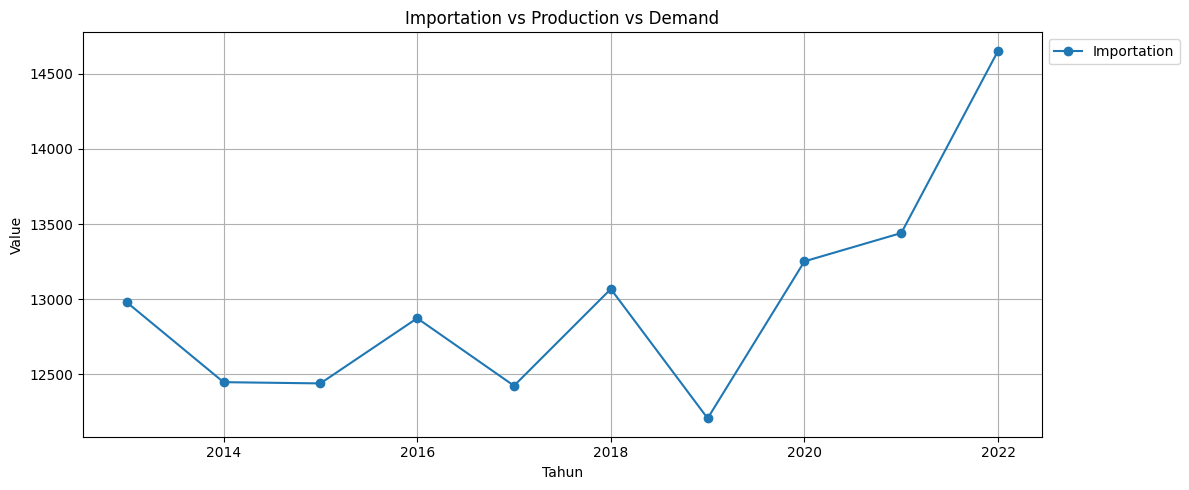

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Misalnya kamu sudah punya DataFrame `datas` berisi 4080 baris (10 tahun × 408)
# Buat list tahun berulang sebanyak 408 kali per tahun
years = list(range(2013, 2023))  # 2013–2022
datas['Year'] = [year for year in years for _ in range(408)]

# Hitung rata-rata per tahun
grouped = datas.groupby('Year')[['Price']].mean()

# Plot rata-rata tahunan
plt.figure(figsize=(12, 5))

plt.plot(grouped.index, grouped['Price'], marker='o', label='Importation')
plt.xlabel("Tahun")
plt.ylabel("Value")
plt.title("Importation vs Production vs Demand")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## 6) SCATTER PLOT

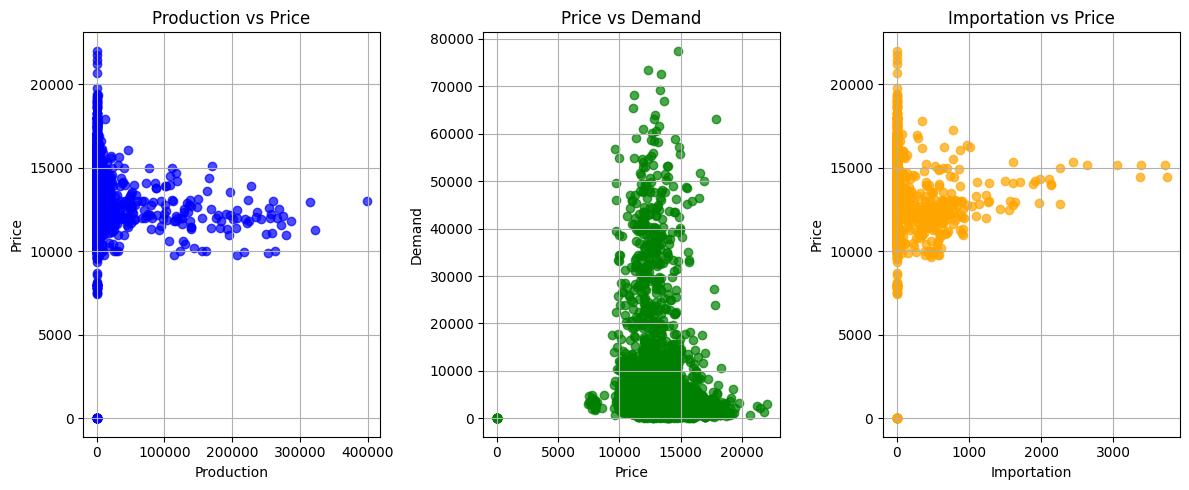

In [9]:
import matplotlib.pyplot as plt

# Asumsikan datas memiliki kolom: 'Production', 'Price', 'Demand', 'Importation'

plt.figure(figsize=(12, 5))

# 1. Production vs Price
plt.subplot(131)
plt.scatter(datas['Production'], datas['Price'], alpha=0.7, color='blue')
plt.xlabel("Production")
plt.ylabel("Price")
plt.title("Production vs Price")
plt.grid(True)

# 2. Price vs Demand
plt.subplot(132)
plt.scatter(datas['Price'], datas['Demand'], alpha=0.7, color='green')
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Price vs Demand")
plt.grid(True)

# 3. Importation vs Price
plt.subplot(133)
plt.scatter(datas['Importation'], datas['Price'], alpha=0.7, color='orange')
plt.xlabel("Importation")
plt.ylabel("Price")
plt.title("Importation vs Price")
plt.grid(True)

plt.tight_layout()
plt.show()


## 7) CORRELATION FEATURES

In [10]:
fitur = datas[['Production','Importation','Demand','Supply','Price','Population','Religious Holiday']]
fitur

Production  Importation  Demand  Supply    Price  Population  \
0            0.0          0.0  3262.0     0.0  12500.0     4811100   
1            0.0          0.0  3127.0     0.0  12500.0     4811100   
2            0.0          0.0  3223.0     0.0  12500.0     4811100   
3            0.0          0.0  4188.0     0.0  12000.0     4811100   
4            0.0          0.0  5076.0     0.0  12659.0     4811100   
...          ...          ...     ...     ...      ...         ...   
4075         0.0          0.0  2460.0     0.0  16120.0     4418600   
4076         0.0          0.0  5308.0     0.0  15846.0     4418600   
4077         0.0          0.0  2538.0     0.0  15425.0     4418600   
4078         0.0          0.0  4808.0     0.0  16357.0     4418600   
4079         0.0          0.0  3470.0     0.0  16473.0     4418600   

      Religious Holiday  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
4075                  0  
4076                  0  
4077                  0  
4078                  0  
4079                  1  

[4080 rows x 7 columns]

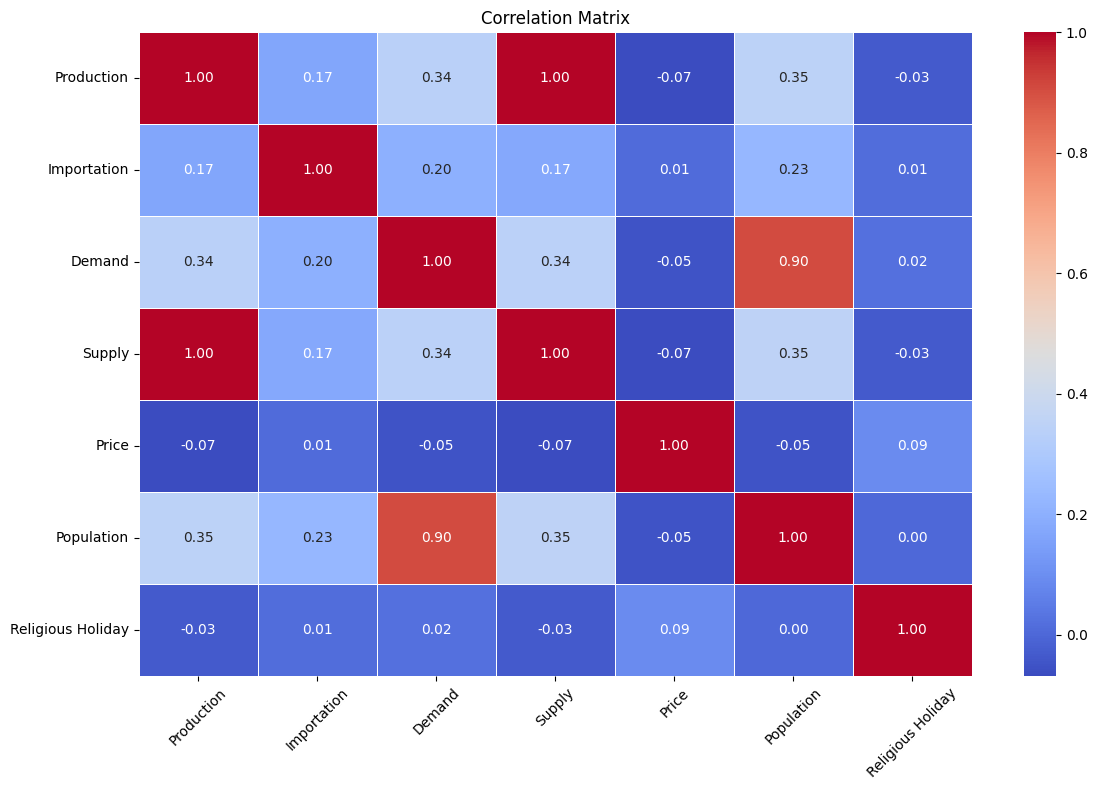

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(fitur.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Asumsikan df adalah DataFrame kamu
# sns.pairplot(fitur)
# plt.suptitle("Pairwise Scatter Plots", y=1.02)
# plt.show()


In [13]:
# # prompt: datas ubah 0 menjadi np.nan

# import numpy as np
# datas = datas.replace(0, np.nan)


# PROCESSING

## 1) IMPUTER FOR NAN VALUES

In [14]:
# prompt: knn imputer colomn Production, Importation,Demand,Price, dengan nilai N = 3

from sklearn.impute import KNNImputer

# Select columns to impute
cols_to_impute = ['Production', 'Demand', 'Supply', 'Price']

# Create KNNImputer object
imputer = KNNImputer(n_neighbors=3)

# Fit and transform the selected columns
datas[cols_to_impute] = imputer.fit_transform(datas[cols_to_impute])
datas


Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  
0        4811100                  0  
1        4811100                  0  
2        4811100                  0  
3        4811100                  0  
4        4811100                  0  
...          ...                ...  
4075     4418600                  0  
4076     4418600                  0  
4077     4418600                  0  
4078     4418600                  0  
4079     4418600                  1  

[4080 rows x 10 columns]

# PANEL DATA TEST

# 1) KOLMOGOROV SMIRNOV

In [15]:
import pandas as pd
from scipy.stats import kstest, norm

import pandas as pd
from scipy.stats import kstest, norm

# Misal data kamu sudah dimuat ke variabel datas (DataFrame)

# Fungsi bantu untuk normality test KS
def normality_ks_test(data, col):
    # Normalisasi data supaya mean=0, std=1 (standar normal)
    standardized = (data[col] - data[col].mean()) / data[col].std()
    
    # Lakukan uji KS dengan distribusi normal standar
    stat, p_value = kstest(standardized.dropna(), 'norm')
    
    print(f"Kolom: {col}")
    print(f"  Statistik KS = {stat:.4f}")
    print(f"  p-value     = {p_value:.4f}")
    if p_value > 0.05:
        print("  -> Distribusi data kemungkinan NORMAL ")
    else:
        print("  -> Distribusi data kemungkinan TIDAK NORMAL ")

# Pilih kolom numerik saja untuk diuji
numeric_cols = datas.select_dtypes(include=['number']).columns

# Jalankan test untuk tiap kolom numerik
for col in numeric_cols:
    normality_ks_test(datas, col)




Kolom: Year
  Statistik KS = 0.1079
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Month
  Statistik KS = 0.0988
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Production
  Statistik KS = 0.4209
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Importation
  Statistik KS = 0.4766
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Demand
  Statistik KS = 0.2675
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Supply
  Statistik KS = 0.4197
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Price
  Statistik KS = 0.1241
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Population
  Statistik KS = 0.2911
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Religious Holiday
  Statistik KS = 0.5067
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

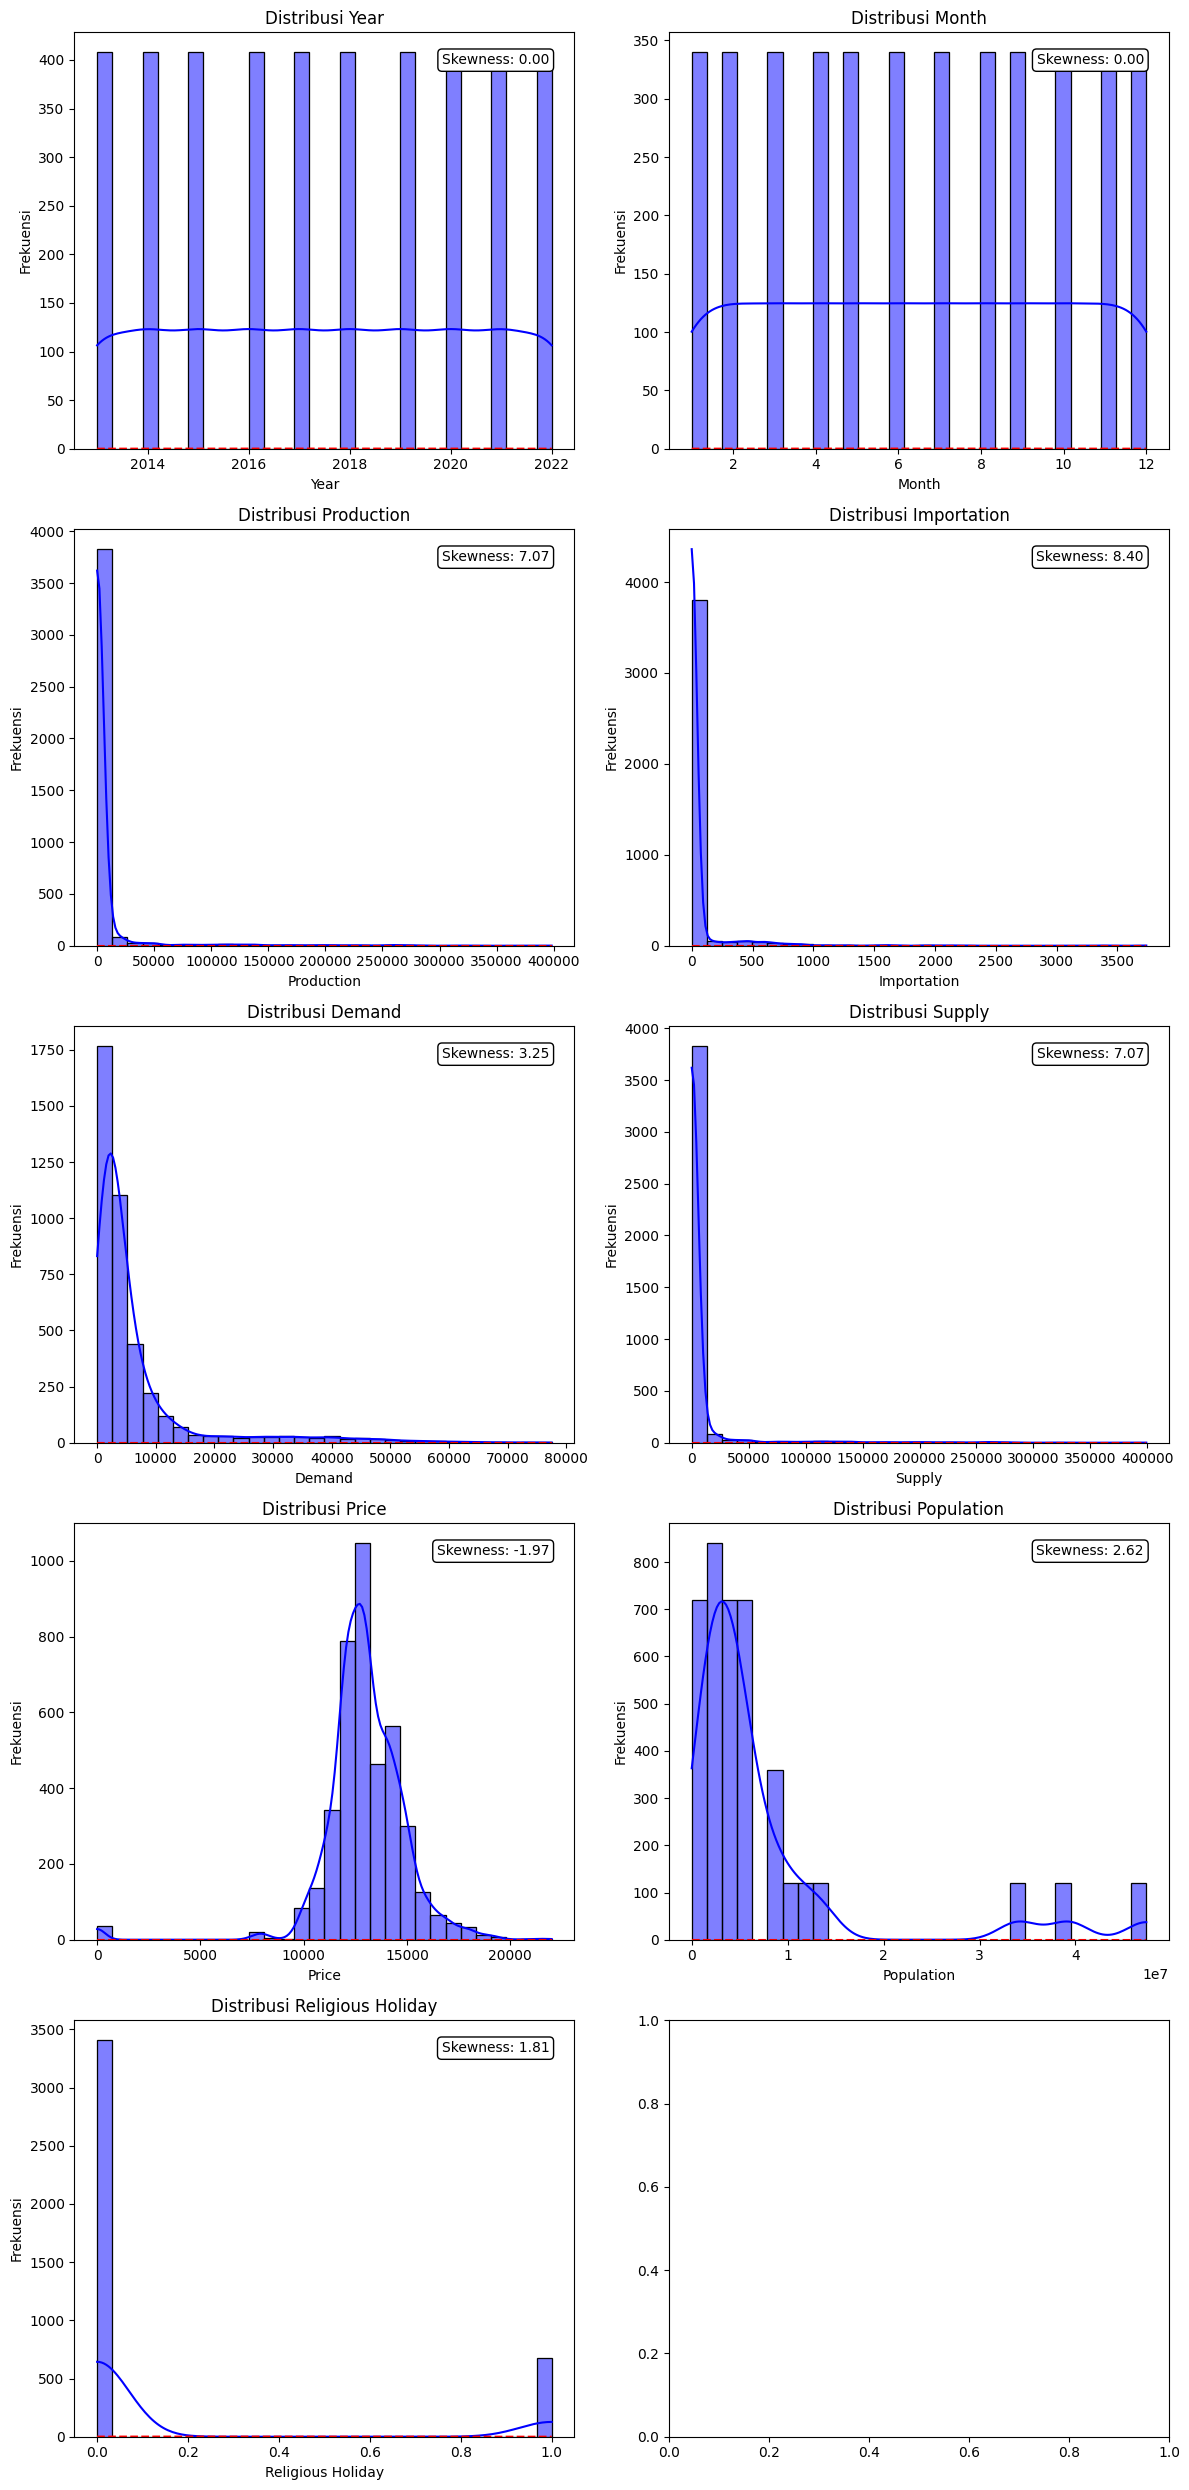

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew

def plot_distributions(data, numeric_cols):
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 1) // 2  # Menghitung jumlah baris
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))  # Subplot dengan 2 kolom
    
    for i, col in enumerate(numeric_cols):
        row, col_idx = divmod(i, 2)  # Menentukan posisi subplot
        ax = axes[row, col_idx]

        # Histogram dengan kurva KDE
        sns.histplot(data[col], kde=True, bins=30, color='blue', alpha=0.5, ax=ax)
        
        # Tambahkan distribusi normal standar
        x_vals = np.linspace(data[col].min(), data[col].max(), 100)
        ax.plot(x_vals, norm.pdf(x_vals, data[col].mean(), data[col].std()), color='red', linestyle='dashed')

        # Hitung skewness
        skew_val = skew(data[col].dropna())

        # Tambahkan teks skewness ke plot
        ax.text(0.95, 0.95, f'Skewness: {skew_val:.2f}', 
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

        ax.set_title(f'Distribusi {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frekuensi')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan:
plot_distributions(datas, numeric_cols)


# 2) STATIONARY ADF

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data, col):
    print(f"ADF Test untuk kolom: {col}")
    
    # Ambil data kolom dan drop NA
    series = data[col].dropna()
    
    # Jalankan ADF test
    result = adfuller(series)
    
    print(f"  Test Statistic   : {result[0]:.4f}")
    print(f"  p-value          : {result[1]:.4f}")
    print(f"  Used Lag         : {result[2]}")
    print(f"  Number of Obs    : {result[3]}")
    print("  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key} : {value:.4f}")
        
    if result[1] < 0.05:
        print("  -> Data stasioner (tolak H0)\n")
    else:
        print("  -> Data tidak stasioner (gagal tolak H0)\n")

# Contoh: tes ADF untuk semua kolom numerik (kecuali Year, Month kalau mau)
for col in numeric_cols:
    adf_test(datas, col)


ADF Test untuk kolom: Year
  Test Statistic   : -0.5216
  p-value          : 0.8877
  Used Lag         : 0
  Number of Obs    : 4079
  Critical Values:
    1% : -3.4320
    5% : -2.8622
    10% : -2.5671
  -> Data tidak stasioner (gagal tolak H0)

ADF Test untuk kolom: Month
  Test Statistic   : -1762549166368776.5000
  p-value          : 0.0000
  Used Lag         : 12
  Number of Obs    : 4067
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5671
  -> Data stasioner (tolak H0)

ADF Test untuk kolom: Production
  Test Statistic   : -4.9409
  p-value          : 0.0000
  Used Lag         : 31
  Number of Obs    : 4048
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5672
  -> Data stasioner (tolak H0)

ADF Test untuk kolom: Importation
  Test Statistic   : -5.4599
  p-value          : 0.0000
  Used Lag         : 31
  Number of Obs    : 4048
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5672
  -> Data stasioner (tolak H0)

ADF Test unt

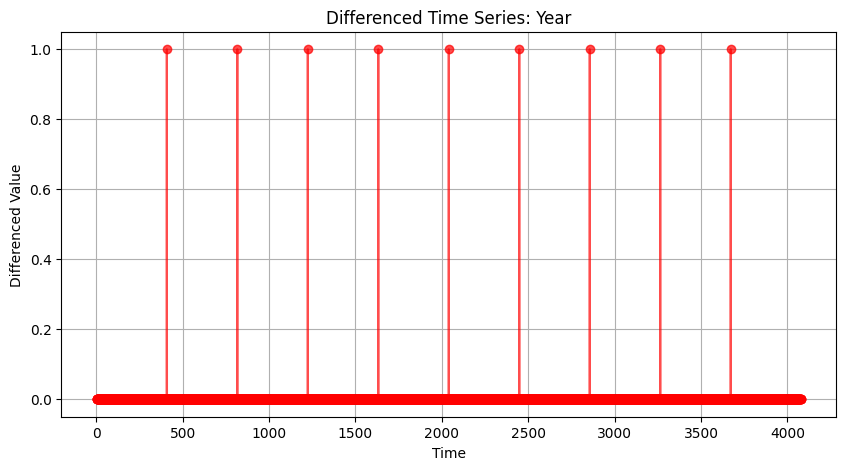

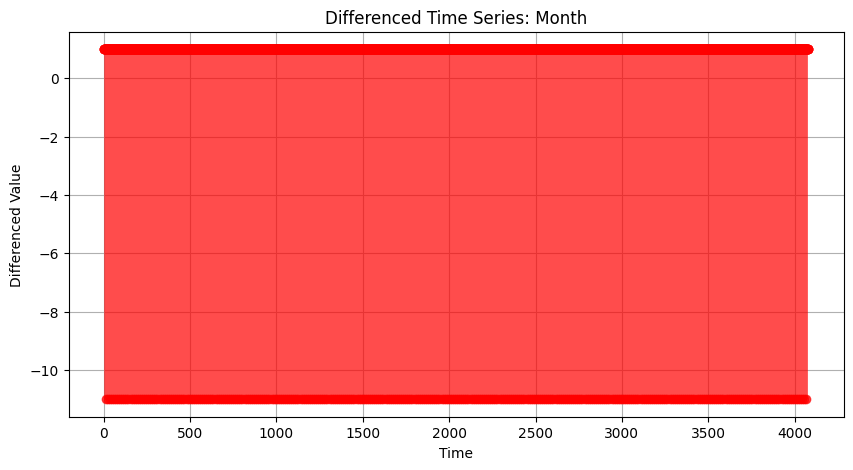

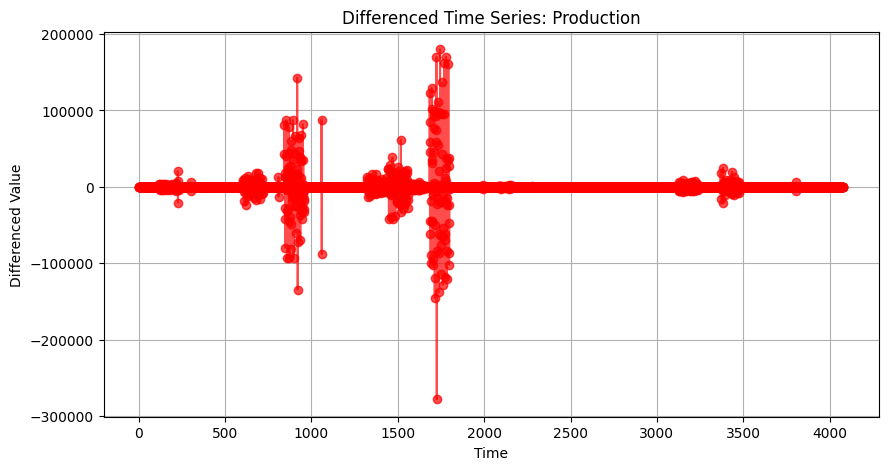

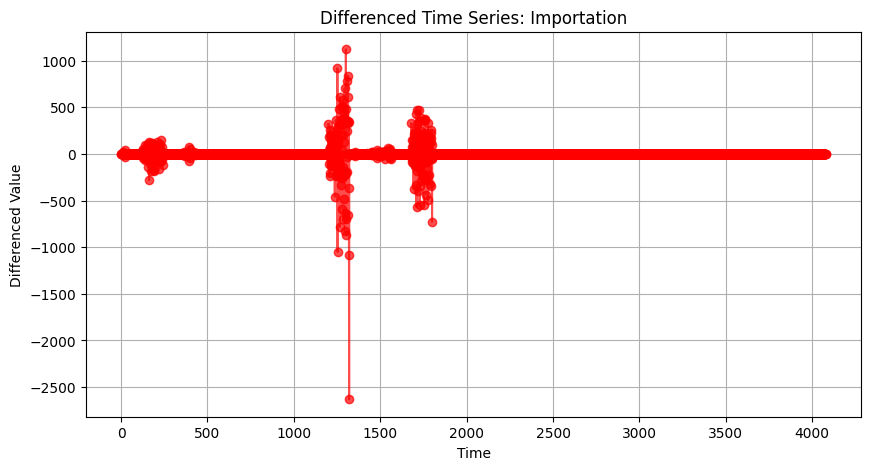

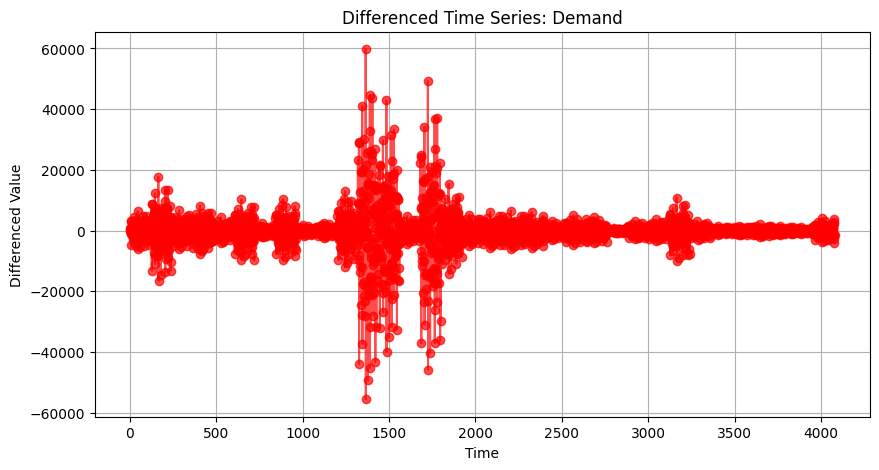

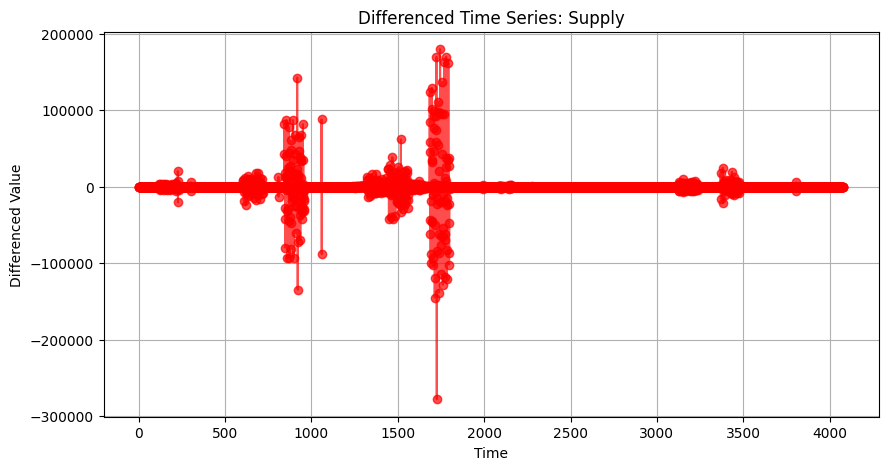

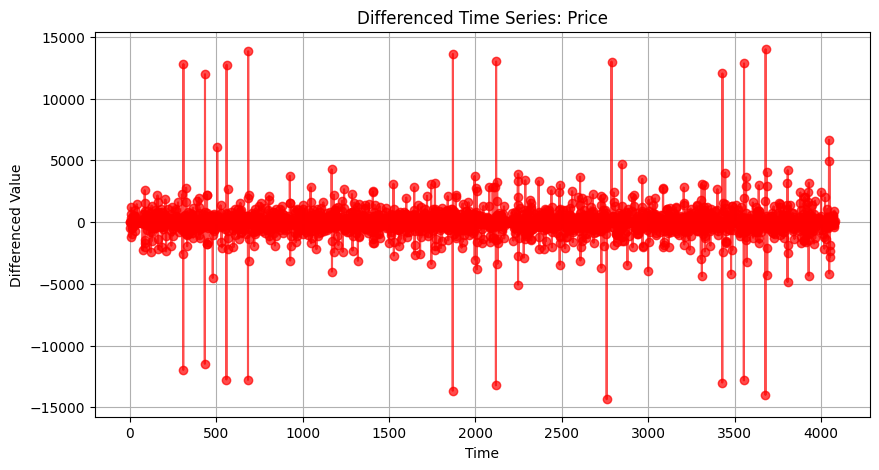

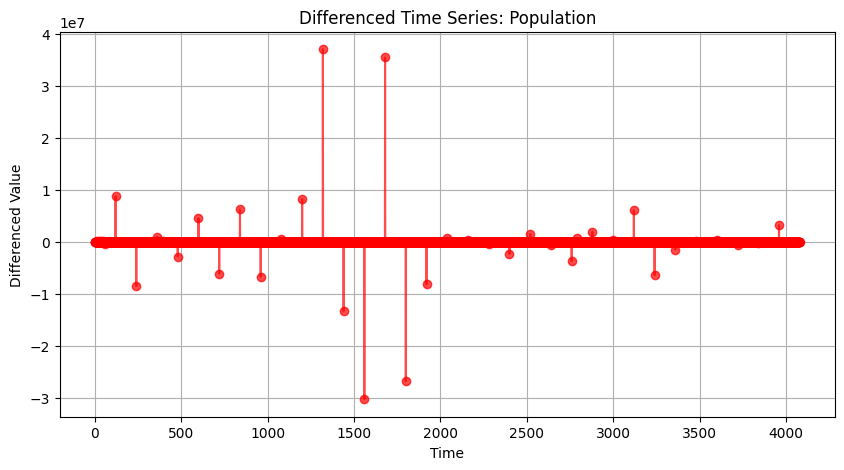

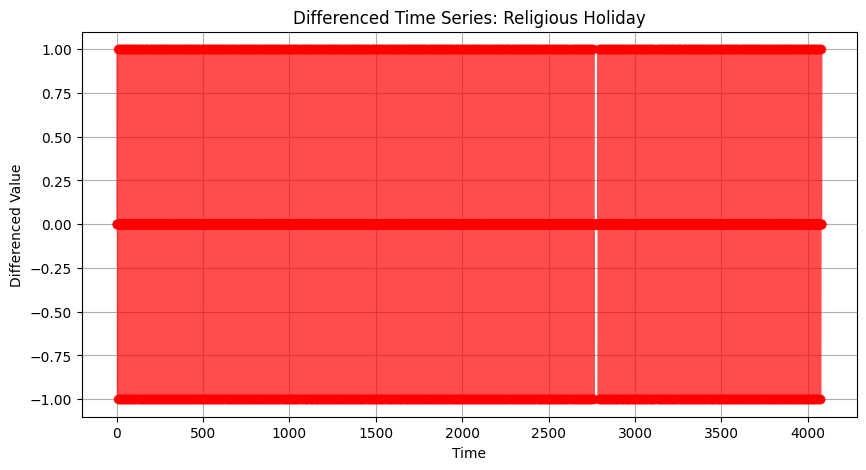

In [18]:
def plot_differencing(data, col):
    plt.figure(figsize=(10, 5))
    plt.plot(data[col].diff(), marker='o', linestyle='-', color='red', alpha=0.7)
    plt.title(f'Differenced Time Series: {col}')
    plt.xlabel('Time')
    plt.ylabel('Differenced Value')
    plt.grid(True)
    plt.show()

for col in numeric_cols:
    plot_differencing(datas, col)

# 3) MULTI-COLINEARITY (VIF)

In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Pilih hanya fitur numerik yang ingin dicek multikolinearitasnya
features = ['Production', 'Importation', 'Demand', 'Supply', 'Price', 'Population', 
            'Religious Holiday']

# Ambil subset data untuk fitur tersebut (drop NA jika ada)
X = datas[features].dropna()

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


             Feature           VIF
0         Production  1.616207e+09
1        Importation  1.007520e+05
2             Demand  7.775523e+00
3             Supply  1.621400e+09
4              Price  1.692085e+00
5         Population  8.448237e+00
6  Religious Holiday  1.211896e+00


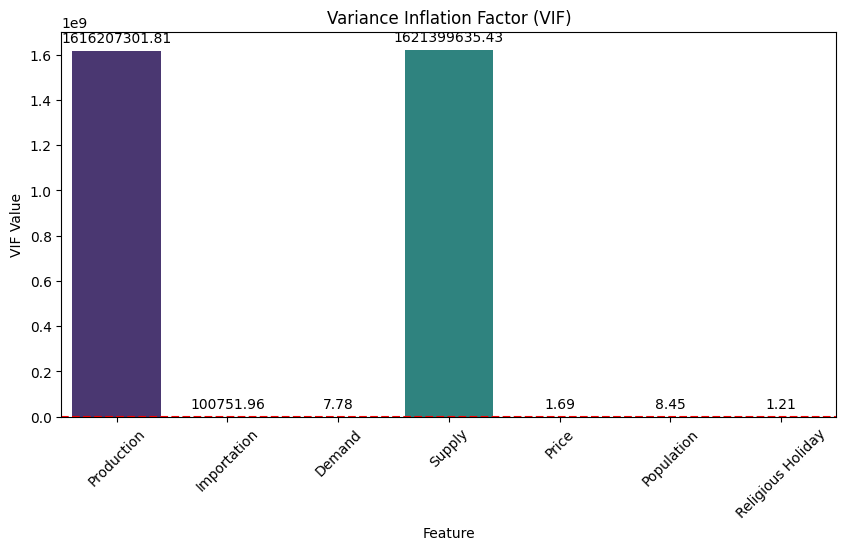

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot VIF dengan angka di atas batang
def plot_vif(vif_data):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x='Feature', y='VIF', data=vif_data, palette='viridis')
    
    # Tambahkan nilai di atas batang
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
    plt.axhline(y=5, color='red', linestyle='dashed')  # Garis batas VIF=5
    plt.xticks(rotation=45)
    plt.title('Variance Inflation Factor (VIF)')
    plt.xlabel('Feature')
    plt.ylabel('VIF Value')
    plt.show()

plot_vif(vif_data)

## 4) HOMOSCEDASITY (Breusch Pagan)

In [21]:
datas.columns

Index(['Province', 'Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Price', 'Population', 'Religious Holiday'],
      dtype='object')

In [22]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Misal kita buat model regresi sederhana dulu (contoh dengan 'Price' sebagai target)
features = ['Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Population', 'Religious Holiday']
X = datas[features]
y = datas['Price']

# Tambahkan konstanta (intercept) untuk regresi
X = sm.add_constant(X)

# Fit model OLS
model = sm.OLS(y, X).fit()

# Lakukan uji Breusch-Pagan
bp_test = het_breuschpagan(model.resid, model.model.exog)

# Hasil test
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': 24.716891756139567, 'p-value': 0.001735842847766663, 'f-value': 3.10158574794358, 'f p-value': 0.0017098987169526646}


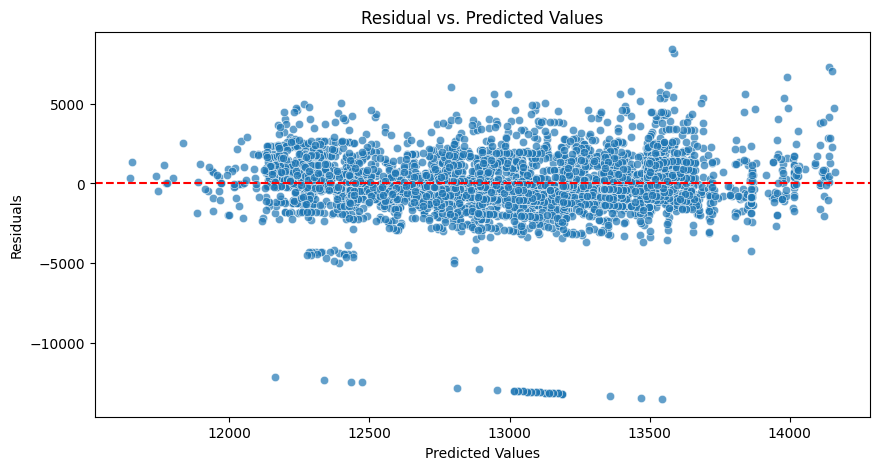

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(model):
    plt.figure(figsize=(10, 5))
    
    predicted_values = model.fittedvalues
    residuals = model.resid
    
    sns.scatterplot(x=predicted_values, y=residuals, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='dashed')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs. Predicted Values')
    plt.show()

plot_residuals(model)

# MODELS FOR PANEL DATA

## 1) POOLED OLS

In [24]:
kolom_fitur = fitur.columns
kolom_fitur

Index(['Production', 'Importation', 'Demand', 'Supply', 'Price', 'Population',
       'Religious Holiday'],
      dtype='object')

In [25]:
# Perform PooledOLS
datas['YearMonth'] = pd.to_datetime(datas[['Year', 'Month']].assign(DAY=1))
datas

Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  YearMonth  
0        4811100                  0 2013-01-01  
1        4811100                  0 2013-02-01  
2        4811100                  0 2013-03-01  
3        4811100                  0 2013-04-01  
4        4811100                  0 2013-05-01  
...          ...                ...        ...  
4075     4418600                  0 2022-08-01  
4076     4418600                  0 2022-09-01  
4077     4418600                  0 2022-10-01  
4078     4418600                  0 2022-11-01  
4079     4418600                  1 2022-12-01  

[4080 rows x 11 columns]

In [26]:
# Perform PooledOLS
datas['YearMonth'] = pd.to_datetime(datas[['Year', 'Month']].assign(DAY=1))

data = datas.set_index(['Province','YearMonth']).sort_values(by=['YearMonth','Province'])
data
# kolom_fitur = fitur.columns
# # define predictor and response variables
X = data[['Production',	'Importation', 'Demand','Supply','Population',	
          'Religious Holiday']]
Y = data[['Price']]

exog = sm.tools.tools.add_constant(X)
endog = Y
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(pooledOLS_res.summary)

# # Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Price   R-squared:                        0.0146
Estimator:                  PooledOLS   R-squared (Between):              0.0473
No. Observations:                4080   R-squared (Within):               0.0088
Date:                Mon, Jun 02 2025   R-squared (Overall):              0.0146
Time:                        06:55:57   Log-likelihood                -3.683e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.056
Entities:                          34   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(6,4073)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             109.80
                            

In [27]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([data, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(Y).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('White Test: ',dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('Breusch-Pagan: ',dict(zip(labels, breusch_pagan_test_results)))

# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual'])
print('Durbin-Watson:', durbin_watson_test_results)

White Test:  {'LM-Stat': 4071.161757546827, 'LM p-val': 0.0, 'F-Stat': 938994.7477374597, 'F p-val': 0.0}
Breusch-Pagan:  {'LM-Stat': 1003.5757967766086, 'LM p-val': 2.999286424871543e-220, 'F-Stat': 1330.3048698443201, 'F p-val': 2.4608662322457793e-252}
Durbin-Watson: 1.3823519271087044


## 2) FEM & REM

In [28]:
# FEM / REM Model
exog = sm.tools.tools.add_constant(X)
endog = Y
# random effects model
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True)
fe_res = model_fe.fit()
#print results
print(re_res)
print('\n')
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Price   R-squared:                        0.0123
Estimator:              RandomEffects   R-squared (Between):             -0.0371
No. Observations:                4080   R-squared (Within):               0.0127
Date:                Mon, Jun 02 2025   R-squared (Overall):              0.0052
Time:                        06:55:57   Log-likelihood                -3.651e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.4875
Entities:                          34   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(6,4073)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             8.4875
                            

In [29]:
# Hausman Test
def hausman(fe, re):
    # ambil parameter yang sama
    common_coef = fe.params.index.intersection(re.params.index)
    
    b = fe.params[common_coef]
    B = re.params[common_coef]
    v_b = fe.cov.loc[common_coef, common_coef]
    v_B = re.cov.loc[common_coef, common_coef]

    diff = b - B
    try:
        chi2 = np.dot(diff.T, la.inv(v_b - v_B).dot(diff))
        df = len(diff)
        pval = stats.chi2.sf(chi2, df)
    except np.linalg.LinAlgError:
        chi2, df, pval = np.nan, len(diff), np.nan

    return chi2, df, pval


hausman_results = hausman(fe_res, re_res)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))
print('\n')
if hausman_results[2] > 0.05:
    # Random Effect
    print('Random Effect')
    print(re_res.params)
    # Store values for checking homoskedasticity graphically
    fittedvals = re_res.predict().fitted_values
    residuals = re_res.resids
else:
    # Fixed Effect
    print('Fixed Effect')
    print(fe_res.params)
    # Store values for checking homoskedasticity graphically
    fittedvals = fe_res.predict().fitted_values
    residuals = fe_res.resids


chi-Squared: 1481.4875149844952
degrees of freedom: 7
p-Value: 0.0


Fixed Effect
const               -110879.185814
Production              -13.424293
Importation             -12.657430
Demand                   -0.001841
Supply                   13.424258
Population                0.016117
Religious Holiday       410.116527
Name: parameter, dtype: float64


In [30]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
panel_dataset = pd.concat([data, residuals], axis=1)
exog = sm.tools.tools.add_constant(Y).fillna(0)
white_test_results = het_white(panel_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('White Test: ',dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(panel_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('Breusch-Pagan: ',dict(zip(labels, breusch_pagan_test_results)))

# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(panel_dataset['residual'])
print('Durbin-Watson:', durbin_watson_test_results)

White Test:  {'LM-Stat': 1325.858710582467, 'LM p-val': 1.2400497391766193e-288, 'F-Stat': 981.3450718405084, 'F p-val': 0.0}
Breusch-Pagan:  {'LM-Stat': 70.38334384098545, 'LM p-val': 4.8830477113681574e-17, 'F-Stat': 71.58372004033171, 'F p-val': 3.656493582849666e-17}
Durbin-Watson: 1.788104486019827


# GWPR

## 1) LOAD PETA INDONESIA

In [31]:
maps = gpd.read_file(
    "/kaggle/input/data-gwpr/indonesia.geojson"
)
maps

cartodb_id    country  id_1                         slug  \
0           16  Indonesia     1               indonesia-aceh   
1            2  Indonesia    31      indonesia-sumaterabarat   
2            8  Indonesia    34         indonesia-yogyakarta   
3           20  Indonesia    33      indonesia-sumaterautara   
4            7  Indonesia     3     indonesia-bangkabelitung   
5            5  Indonesia     7         indonesia-papuabarat   
6            4  Indonesia    12          indonesia-jawatimur   
7           10  Indonesia    13    indonesia-kalimantanbarat   
8            3  Indonesia    14  indonesia-kalimantanselatan   
9            6  Indonesia    16    indonesia-kalimantantimur   
10           9  Indonesia    18      indonesia-kepulauanriau   
11          11  Indonesia    19            indonesia-lampung   
12          14  Indonesia    21             indonesia-maluku   
13          19  Indonesia    20        indonesia-malukuutara   
14          15  Indonesia    22  indonesia-nusatenggarabarat   
15          29  Indonesia    23  indonesia-nusatenggaratimur   
16           1  Indonesia    24              indonesia-papua   
17          12  Indonesia    25               indonesia-riau   
18          18  Indonesia    27    indonesia-sulawesiselatan   
19          24  Indonesia     5           indonesia-bengkulu   
20          26  Indonesia    28     indonesia-sulawesitengah   
21          27  Indonesia    30      indonesia-sulawesiutara   
22          28  Indonesia    29   indonesia-sulawesitenggara   
23          31  Indonesia     2               indonesia-bali   
24          30  Indonesia     4             indonesia-banten   
25          32  Indonesia     6          indonesia-gorontalo   
26          25  Indonesia     8        indonesia-jakartaraya   
27          34  Indonesia     9              indonesia-jambi   
28          22  Indonesia    10          indonesia-jawabarat   
29          23  Indonesia    11         indonesia-jawatengah   
30          33  Indonesia    15   indonesia-kalimantantengah   
31          17  Indonesia    26      indonesia-sulawesibarat   
32          21  Indonesia    32    indonesia-sumateraselatan   
33          34  Indonesia    35    indonesia-kalimantanutara   

                  state                                           geometry  
0                  Aceh  MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
1        Sumatera Barat  MULTIPOLYGON (((99.17167 -1.50250, 99.20500 -1...  
2            Yogyakarta  MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
3        Sumatera Utara  MULTIPOLYGON (((98.71384 3.76947, 99.05473 3.6...  
4       Bangka-Belitung  MULTIPOLYGON (((105.34754 -1.84469, 105.39079 ...  
5           Papua Barat  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
6            Jawa Timur  MULTIPOLYGON (((113.59208 -7.71486, 113.66695 ...  
7      Kalimantan Barat  MULTIPOLYGON (((108.92462 0.55861, 108.92167 0...  
8    Kalimantan Selatan  MULTIPOLYGON (((114.51278 -3.54225, 114.51806 ...  
9      Kalimantan Timur  MULTIPOLYGON (((117.01733 -1.16421, 116.93333 ...  
10       Kepulauan Riau  MULTIPOLYGON (((103.99194 1.13472, 104.01361 1...  
11              Lampung  MULTIPOLYGON (((105.81611 -5.57617, 105.79945 ...  
12               Maluku  MULTIPOLYGON (((128.28972 -3.62194, 128.25694 ...  
13         Maluku Utara  MULTIPOLYGON (((127.57263 0.86478, 127.54813 0...  
14  Nusa Tenggara Barat  MULTIPOLYGON (((118.83139 -6.56889, 118.84111 ...  
15  Nusa Tenggara Timur  MULTIPOLYGON (((124.22305 -10.15944, 124.10889...  
16                Papua  MULTIPOLYGON (((140.68666 -2.47778, 140.74722 ...  
17                 Riau  MULTIPOLYGON (((101.91405 -0.92096, 101.84528 ...  
18     Sulawesi Selatan  MULTIPOLYGON (((119.59165 -4.55424, 119.59671 ...  
19             Bengkulu  MULTIPOLYGON (((102.56528 -4.17972, 102.28000 ...  
20      Sulawesi Tengah  MULTIPOLYGON (((121.63028 -0.12361, 121.65417 ...  
21       Sulawesi Utara  MULTIPOLYGON (((125.24160 1.50043, 125.20739

In [32]:
print("maps:", maps["state"].unique())
# print("datas:", panel_dataset["Province"].unique())


maps: ['Aceh' 'Sumatera Barat' 'Yogyakarta' 'Sumatera Utara' 'Bangka-Belitung'
 'Papua Barat' 'Jawa Timur' 'Kalimantan Barat' 'Kalimantan Selatan'
 'Kalimantan Timur' 'Kepulauan Riau' 'Lampung' 'Maluku' 'Maluku Utara'
 'Nusa Tenggara Barat' 'Nusa Tenggara Timur' 'Papua' 'Riau'
 'Sulawesi Selatan' 'Bengkulu' 'Sulawesi Tengah' 'Sulawesi Utara'
 'Sulawesi Tenggara' 'Bali' 'Banten' 'Gorontalo' 'Jakarta Raya' 'Jambi'
 'Jawa Barat' 'Jawa Tengah' 'Kalimantan Tengah' 'Sulawesi Barat'
 'Sumatera Selatan' 'Kalimantan Utara']


In [33]:
# Gabung dataframe
maps["Province"] = maps["state"]
merged = maps.merge(panel_dataset, on="Province", how="right")

# Pastikan hasil adalah GeoDataFrame
import geopandas as gpd
merged = gpd.GeoDataFrame(merged, geometry="geometry")
merged

cartodb_id    country  id_1                  slug        state  \
0             16  Indonesia     1        indonesia-aceh         Aceh   
1             16  Indonesia     1        indonesia-aceh         Aceh   
2             16  Indonesia     1        indonesia-aceh         Aceh   
3             16  Indonesia     1        indonesia-aceh         Aceh   
4             16  Indonesia     1        indonesia-aceh         Aceh   
...          ...        ...   ...                   ...          ...   
4075           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4076           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4077           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4078           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4079           5  Indonesia     7  indonesia-papuabarat  Papua Barat   

                                               geometry     Province  Year  \
0     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
1     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
2     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
3     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
4     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
...                                                 ...          ...   ...   
4075  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4076  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4077  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4078  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4079  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   

      Month  Production  Importation  Demand  Supply    Price  Population  \
0         1         0.0         0.00  3262.0    0.00  12500.0     4811100   
1         1         0.0        16.02  3399.0   16.02  12000.0     4906800   
2         1         0.0         0.00  2902.0    0.00  11000.0     5020000   
3         1         0.0         0.00  2529.0    0.00  13000.0     5096200   
4         1         0.0         0.00  4706.0    0.00  14500.0     5189500   
...     ...         ...          ...     ...     ...      ...         ...   
4075     12         0.0         0.00   802.0    0.00  13938.0     1183300   
4076     12         0.0         0.00   705.0    0.00  14416.0     1183300   
4077     12         0.0         0.00   651.0    0.00  14650.0     1183300   
4078     12         0.0         0.00  1014.0    0.00  14750.0     1183300   
4079     12         0.0         0.00   636.0    0.00  15750.0     1183300   

      Religious Holiday     residual  
0                     0   564.541202  
1                     0 -1489.866047  
2                     0 -4302.914627  
3                     0 -3531.699064  
4                     0 -3531.386379  
...                 ...          ...  
4075                  1 -1113.940301  
4076                  1  -636.118852  
4077                  1  -402.218252  
4078                  1  -301.550064  
4079                  1   697.754137  

[4080 rows x 17 columns]

## 2) GABUNG KOORDINAT PETA DENGAN DATASET

In [34]:
data = merged.drop(['cartodb_id','country',	'id_1',	'slug',	'state','geometry'],axis=1)
data

Province  Year  Month  Production  Importation  Demand  Supply  \
0            Aceh  2013      1         0.0         0.00  3262.0    0.00   
1            Aceh  2013      1         0.0        16.02  3399.0   16.02   
2            Aceh  2013      1         0.0         0.00  2902.0    0.00   
3            Aceh  2013      1         0.0         0.00  2529.0    0.00   
4            Aceh  2013      1         0.0         0.00  4706.0    0.00   
...           ...   ...    ...         ...          ...     ...     ...   
4075  Papua Barat  2022     12         0.0         0.00   802.0    0.00   
4076  Papua Barat  2022     12         0.0         0.00   705.0    0.00   
4077  Papua Barat  2022     12         0.0         0.00   651.0    0.00   
4078  Papua Barat  2022     12         0.0         0.00  1014.0    0.00   
4079  Papua Barat  2022     12         0.0         0.00   636.0    0.00   

        Price  Population  Religious Holiday     residual  
0     12500.0     4811100                  0   564.541202  
1     12000.0     4906800                  0 -1489.866047  
2     11000.0     5020000                  0 -4302.914627  
3     13000.0     5096200                  0 -3531.699064  
4     14500.0     5189500                  0 -3531.386379  
...       ...         ...                ...          ...  
4075  13938.0     1183300                  1 -1113.940301  
4076  14416.0     1183300                  1  -636.118852  
4077  14650.0     1183300                  1  -402.218252  
4078  14750.0     1183300                  1  -301.550064  
4079  15750.0     1183300                  1   697.754137  

[4080 rows x 11 columns]

In [35]:
data = pd.concat([data, merged['geometry']],axis=1)
data

Province  Year  Month  Production  Importation  Demand  Supply  \
0            Aceh  2013      1         0.0         0.00  3262.0    0.00   
1            Aceh  2013      1         0.0        16.02  3399.0   16.02   
2            Aceh  2013      1         0.0         0.00  2902.0    0.00   
3            Aceh  2013      1         0.0         0.00  2529.0    0.00   
4            Aceh  2013      1         0.0         0.00  4706.0    0.00   
...           ...   ...    ...         ...          ...     ...     ...   
4075  Papua Barat  2022     12         0.0         0.00   802.0    0.00   
4076  Papua Barat  2022     12         0.0         0.00   705.0    0.00   
4077  Papua Barat  2022     12         0.0         0.00   651.0    0.00   
4078  Papua Barat  2022     12         0.0         0.00  1014.0    0.00   
4079  Papua Barat  2022     12         0.0         0.00   636.0    0.00   

        Price  Population  Religious Holiday     residual  \
0     12500.0     4811100                  0   564.541202   
1     12000.0     4906800                  0 -1489.866047   
2     11000.0     5020000                  0 -4302.914627   
3     13000.0     5096200                  0 -3531.699064   
4     14500.0     5189500                  0 -3531.386379   
...       ...         ...                ...          ...   
4075  13938.0     1183300                  1 -1113.940301   
4076  14416.0     1183300                  1  -636.118852   
4077  14650.0     1183300                  1  -402.218252   
4078  14750.0     1183300                  1  -301.550064   
4079  15750.0     1183300                  1   697.754137   

                                               geometry  
0     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
1     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
2     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
3     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
4     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
...                                                 ...  
4075  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4076  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4077  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4078  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4079  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  

[4080 rows x 12 columns]

## 3) SEBARAN HARGA GULA TIAP PROVINSI DENGAN VISUAL PETA

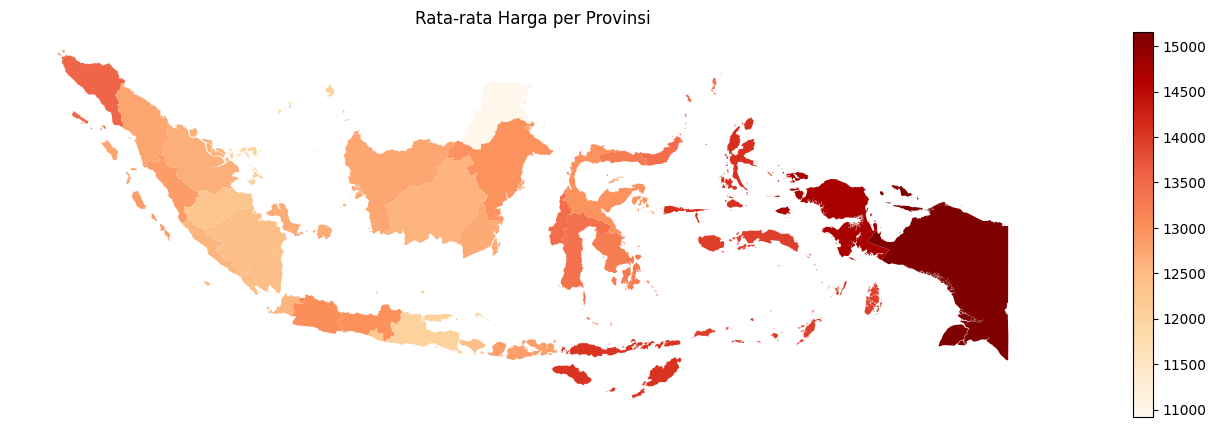

In [36]:
## import matplotlib.pyplot as plt

# Ambil data rata-rata per provinsi (terbaru atau agregat)
avg_price = data.groupby("Province")["Price"].mean().reset_index()
map_price = maps.merge(avg_price, on="Province", how="left")

# Plot
map_price.plot(column="Price", cmap="OrRd", legend=True, figsize=(20, 5))
plt.title("Rata-rata Harga per Provinsi")
plt.axis("off")
plt.show()


## 4) FIX DATA PANEL FOR GWPR

In [37]:
datas_panel = data.set_index(['Province', 'Year','Month']).sort_index()

# Contoh cek
print(datas_panel.head())

                     Production  Importation  Demand  Supply    Price  \
Province Year Month                                                     
Aceh     2013 1             0.0         0.00  3262.0    0.00  12500.0   
              1             0.0        16.02  3399.0   16.02  12000.0   
              1             0.0         0.00  2902.0    0.00  11000.0   
              1             0.0         0.00  2529.0    0.00  13000.0   
              1             0.0         0.00  4706.0    0.00  14500.0   

                     Population  Religious Holiday     residual  \
Province Year Month                                               
Aceh     2013 1         4811100                  0   564.541202   
              1         4906800                  0 -1489.866047   
              1         5020000                  0 -4302.914627   
              1         5096200                  0 -3531.699064   
              1         5189500                  0 -3531.386379   

                  

In [38]:
datas_panel

Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  
Province   Year Month                                                     
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
...                                                                  ...  
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  

[4080 rows x 9 columns]

## 5) AMBIL CENTROID

In [39]:
import geopandas as gpd

# Pastikan ini adalah GeoDataFrame (bukan DataFrame biasa)
datas_panel = gpd.GeoDataFrame(datas_panel, geometry='geometry')

# Atur crs jika belum ada (wajib untuk operasi spasial)
if datas_panel.crs is None:
    datas_panel.set_crs(epsg=4326, inplace=True)  # gunakan WGS84 (lat/lon)

# Ambil centroid dari setiap geometry
datas_panel['centroid'] = datas_panel.geometry.centroid

# Pecah jadi kolom lon dan lat
datas_panel['lon'] = datas_panel['centroid'].x
datas_panel['lat'] = datas_panel['centroid'].y
datas_panel

/tmp/ipykernel_35/3856991978.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  datas_panel['centroid'] = datas_panel.geometry.centroid


Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  \
Province   Year Month                                                      
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
...                                                                  ...   
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   

                                         centroid         lon       lat  
Province   Year Month                                                    
Aceh       2013 1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
...                                           ...         ...       ...  
Yogyakarta 2017 11     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  

[4080 rows x 12 columns]

## GWPR - SCENARIOS 

In [40]:
# import pandas as pd
# import numpy as np
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import t
# import warnings

# warnings.filterwarnings('ignore')

# # Supaya tampilan float di pandas lebih banyak digit
# pd.options.display.float_format = '{:.8f}'.format

# def run_gwr(
#     data,                # DataFrame berisi data (harus ada kolom lon, lat, dan Province)
#     features,            # List fitur prediktor (nama kolom)
#     target,              # Nama kolom target
#     kernel='bisquare',   # Kernel GWR (default bisquare)
#     fixed=True           # Fixed bandwidth (default True)
# ):
#     # Reset index jika perlu
#     data_reset = data.reset_index()

#     # Extract X, y, coords
#     X = data_reset[features].values.astype(float)
#     y = data_reset[target].values.reshape(-1, 1).astype(float)
#     coords = data_reset[['lon', 'lat']].values.astype(float)

#     # Standardisasi fitur dan target
#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#     X_scaled = scaler_X.fit_transform(X)
#     y_scaled = scaler_y.fit_transform(y)

#     # Pastikan tidak ada NaN/Inf
#     assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
#     assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

#     # Cari bandwidth optimal
#     print("Mencari bandwidth optimal...")
#     selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
#     bandwidth = selector.search()
#     print(f"Bandwidth optimal: {bandwidth}")

#     # Fit model GWR
#     gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed)
#     gwr_results = gwr_model.fit()
#     print("GWR fitting selesai.")

#     # Buat dataframe parameter (intercept + features)
#     cols = ['intercept'] + features
#     gwr_df = pd.DataFrame(gwr_results.params, columns=cols)

#     # Hitung t-values dan p-values
#     tvals = gwr_results.filter_tvals()
#     n = len(y_scaled)
#     k = X_scaled.shape[1]
#     df = n - k - 1
#     p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df))

#     # Debug print contoh t-values dan p-values untuk fitur Production
#     prod_index = features.index("Production") + 1  # +1 karena intercept di index 0
#     print("Contoh t-values untuk 'Production':", tvals[:5, prod_index])
#     print("Contoh p-values untuk 'Production':", p_values[:5, prod_index])

#     # Cek nilai unik p-value untuk fitur Production
#     unique_pvals_production = np.unique(np.round(p_values[:, prod_index], decimals=6))
#     print("Nilai unik p-values 'Production' (6 desimal):", unique_pvals_production)

#     # Tambahkan p-value untuk masing-masing fitur (tanpa intercept)
#     for i, var in enumerate(features):
#         gwr_df[f'p_value_{var}'] = p_values[:, i + 1]  # Simpan sebagai float

#     # Evaluasi prediksi
#     y_pred_scaled = gwr_results.predy
#     y_true = scaler_y.inverse_transform(y_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)

#     # Hitung residual dan tambahkan kolom hasil evaluasi
#     residuals = y_true.flatten() - y_pred.flatten()
#     gwr_df['Actual'] = y_true.flatten()
#     gwr_df['Predicted'] = y_pred.flatten()
#     gwr_df['Residual'] = residuals

#     # Susun kolom output
#     output_cols = (
#         features +
#         [f'p_value_{f}' for f in features] +
#         ['Actual', 'Predicted', 'Residual', 'Province']
#     )
#     gwr_df['Province'] = data_reset['Province'].values
#     gwr_df = gwr_df[output_cols]

#     # Evaluasi global model
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     evaluation = {
#         'mse': mse,
#         'rmse': rmse,
#         'mae': mae,
#         'r2': r2
#     }

#     return gwr_df, evaluation


In [41]:
# import pandas as pd
# import numpy as np
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import t
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import warnings
# import contextily

# warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:.8f}'.format

# # Fungsi untuk menampilkan persamaan regresi per provinsi
# def create_equation(df):
#     provinsi = df['Province'].unique()
#     for prov in provinsi:
#         subset = df[df['Province'] == prov]
#         intercept_mean = subset['intercept'].mean()
#         coef1_mean = subset['x1_coef'].mean()
#         coef2_mean = subset['x2_coef'].mean()
#         coef3_mean = subset['x3_coef'].mean()
#         x1_sign = subset['x1_significant'].mean()
#         x2_sign = subset['x2_significant'].mean()
#         x3_sign = subset['x3_significant'].mean()
#         print(f"Region {prov}: y = {intercept_mean:.4f} + {coef1_mean:.4f}*x1 + {coef2_mean:.4f}*x2 + {coef3_mean:.4f}*x3")
#         print(f"x1_sign: {x1_sign:.4f}; x2_sign: {x2_sign:.4f}; x3_sign: {x3_sign:.4f};\n")

# # Fungsi visualisasi peta
# def build_plotmap(dbs, column):
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     dbs.plot(
#         column=column,
#         cmap="viridis",
#         scheme="quantiles",
#         k=4,
#         edgecolor="white",
#         linewidth=0.0,
#         alpha=0.75,
#         legend=True,
#         legend_kwds=dict(loc=0),
#         ax=ax,
#     )
#     contextily.add_basemap(
#         ax,
#         crs=dbs.crs,
#         source=contextily.providers.CartoDB.VoyagerNoLabels,
#     )
#     ax.set_axis_off()
#     plt.title(column)
#     plt.figure(dpi=300)
#     plt.show()

# # Fungsi utama GWR
# def run_gwr(
#     data,                # DataFrame harus ada kolom lon, lat, Province
#     features,            # List fitur prediktor, contoh: ['Production', 'Importation', 'Demand']
#     target,              # Nama kolom target, contoh: 'Price'
#     kernel='bisquare',   # Kernel GWR default
#     fixed=True           # Bandwidth fixed default
# ):
#     data_reset = data.reset_index()

#     X = data_reset[features].values.astype(float)
#     y = data_reset[target].values.reshape(-1, 1).astype(float)
#     coords = data_reset[['lon', 'lat']].values.astype(float)

#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#     X_scaled = scaler_X.fit_transform(X)
#     y_scaled = scaler_y.fit_transform(y)

#     assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
#     assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

#     print("Mencari bandwidth optimal...")
#     selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
#     bandwidth = selector.search(criterion='AICc')
#     print(f"Bandwidth optimal: {bandwidth}")

#     gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed, hat_matrix=True)
#     result_gwr = gwr_model.fit()
#     print("GWR fitting selesai.")

#     # Koefisien hasil GWR
#     coefficients = result_gwr.params
#     print("Shape koefisien:", coefficients.shape)

#     # Tambahkan intercept dan koefisien ke dalam dataframe
#     data_reset['intercept'] = coefficients[:, 0]
#     for i, feature in enumerate(features):
#         data_reset[f'{feature}_coef'] = coefficients[:, i + 1]

#     # Hitung p-values
#     tvals = result_gwr.tvalues
#     df_resid = result_gwr.df_resid
#     p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df_resid))

#     print("\n--- ANALISIS P-VALUE < 0.05 ---")
#     for i, feature in enumerate(features):
#         pval_col = f'{feature}_pvalue'
#         signif_col = f'{feature}_significant'
#         data_reset[pval_col] = p_values[:, i + 1]
#         data_reset[signif_col] = (data_reset[pval_col] < 0.05).astype(int)
#         count_significant = data_reset[signif_col].sum()
#         print(f"Fitur '{feature}': {count_significant} titik signifikan (p < 0.05)")
#         print('='*20)
#         print()

#     # Tampilkan persamaan regresi per provinsi secara default
#     print("--- PERSAMAAN REGRESI PER PROVINSI ---")
#     temp_df = data_reset.copy()
#     # Rename koefisien agar sesuai dengan nama yang dipakai create_equation
#     temp_df = temp_df.rename(columns={
#         f'{features[0]}_coef': 'x1_coef',
#         f'{features[1]}_coef': 'x2_coef',
#         f'{features[2]}_coef': 'x3_coef',
#         f'{features[0]}_significant': 'x1_significant',
#         f'{features[1]}_significant': 'x2_significant',
#         f'{features[2]}_significant': 'x3_significant',
#     })
#     create_equation(temp_df)

#     # Visualisasi peta signifikan
#     first_signif_col = f'{features[0]}_significant'
#     build_plotmap(data_reset, first_signif_col)

#     # Evaluasi
#     y_pred_scaled = result_gwr.predy
#     y_true = scaler_y.inverse_transform(y_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)
#     residuals = y_true.flatten() - y_pred.flatten()

#     output_df = data_reset.copy()
#     output_df['Actual'] = y_true.flatten()
#     output_df['Predicted'] = y_pred.flatten()
#     output_df['Residual'] = residuals

#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     evaluation = {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

#     avg_abs_coefs = np.mean(np.abs(coefficients[:, 1:]), axis=0)
#     max_idx = np.argmax(avg_abs_coefs)
#     fitur_paling_berpengaruh = features[max_idx]

#     print(f"\nFitur paling berpengaruh (berdasarkan rata-rata koefisien absolut): '{fitur_paling_berpengaruh}'")

#     return output_df, evaluation


In [42]:
datas_panel

Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  \
Province   Year Month                                                      
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
...                                                                  ...   
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   

                                         centroid         lon       lat  
Province   Year Month                                                    
Aceh       2013 1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
...                                           ...         ...       ...  
Yogyakarta 2017 11     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  

[4080 rows x 12 columns]

In [43]:
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import t
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import contextily

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.8f}'.format

# Fungsi untuk menampilkan persamaan regresi per provinsi
def create_equation(df, feature_labels):
    provinsi = df['Province'].unique()
    for prov in provinsi:
        subset = df[df['Province'] == prov]
        intercept_mean = subset['intercept'].mean()
        persamaan = f"Region {prov}: y = {intercept_mean:.4f}"

        signif_output = []

        for idx, feature in enumerate(feature_labels):
            coef_col = f'x{idx+1}_coef'
            signif_col = f'x{idx+1}_significant'
            coef_mean = subset[coef_col].mean()
            signif_mean = subset[signif_col].mean()

            if signif_mean >= 0.5:
                persamaan += f" + {coef_mean:.4f}*x{idx+1}"
                signif_output.append(f"x{idx+1}_sign: {signif_mean:.4f}")

        print(persamaan)
        print("; ".join(signif_output))
        print()

# Fungsi untuk menampilkan peta
def build_plotmap(dbs, column):
    f, ax = plt.subplots(1, figsize=(9, 9))
    dbs.plot(
        column=column,
        cmap="viridis",
        scheme="quantiles",
        k=4,
        edgecolor="white",
        linewidth=0.0,
        alpha=0.75,
        legend=True,
        legend_kwds=dict(loc=0),
        ax=ax,
    )
    contextily.add_basemap(
        ax,
        crs=dbs.crs,
        source=contextily.providers.CartoDB.VoyagerNoLabels,
    )
    ax.set_axis_off()
    plt.title(column)
    plt.show()

# Fungsi utama GWR
def run_gwr(
    data,
    features,
    target,
    kernel='bisquare',
    fixed=True
):
    data_reset = data.reset_index()

    X = data_reset[features].values.astype(float)
    y = data_reset[target].values.reshape(-1, 1).astype(float)
    coords = data_reset[['lon', 'lat']].values.astype(float)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
    assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

    print("Mencari bandwidth optimal...")
    selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
    bandwidth = selector.search(criterion='AICc')
    print(f"Bandwidth optimal: {bandwidth}")

    gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed, hat_matrix=True)
    result_gwr = gwr_model.fit()
    print("GWR fitting selesai.")

    coefficients = result_gwr.params
    print("Shape koefisien:", coefficients.shape)

    data_reset['intercept'] = coefficients[:, 0]
    for i, feature in enumerate(features):
        data_reset[f'{feature}_coef'] = coefficients[:, i + 1]

    # Hitung p-value dan tandai signifikan
    tvals = result_gwr.tvalues
    df_resid = result_gwr.df_resid
    p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df_resid))

    print("\n--- ANALISIS P-VALUE < 0.05 ---")
    for i, feature in enumerate(features):
        pval_col = f'{feature}_pvalue'
        signif_col = f'{feature}_significant'
        data_reset[pval_col] = p_values[:, i + 1]
        data_reset[signif_col] = (data_reset[pval_col] < 0.05).astype(int)
        count_significant = data_reset[signif_col].sum()
        print(f"Fitur '{feature}': {count_significant} titik signifikan (p < 0.05)")
        print('='*20)

    # Tampilkan persamaan regresi per provinsi
    print("\n--- PERSAMAAN REGRESI PER PROVINSI ---")
    temp_df = data_reset.copy()
    rename_dict = {}
    for i, feature in enumerate(features):
        rename_dict[f'{feature}_coef'] = f'x{i+1}_coef'
        rename_dict[f'{feature}_significant'] = f'x{i+1}_significant'
    temp_df = temp_df.rename(columns=rename_dict)
    create_equation(temp_df, features)

    # Prediksi dan evaluasi
    y_pred_scaled = result_gwr.predy
    y_true = scaler_y.inverse_transform(y_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled)
    residuals = y_true.flatten() - y_pred.flatten()

    output_df = data_reset.copy()
    output_df['Actual'] = y_true.flatten()
    output_df['Predicted'] = y_pred.flatten()
    output_df['Residual'] = residuals

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evaluation = {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

    avg_abs_coefs = np.mean(np.abs(coefficients[:, 1:]), axis=0)
    max_idx = np.argmax(avg_abs_coefs)
    fitur_paling_berpengaruh = features[max_idx]
    print(f"\nFitur paling berpengaruh (berdasarkan rata-rata koefisien absolut): '{fitur_paling_berpengaruh}'")

    # === Visualisasi peta signifikan ===
    print("\n--- VISUALISASI PETA SIGNIFIKANSI ---")
    for i, feature in enumerate(features):
        signif_col = f'{feature}_significant'
        if signif_col in output_df.columns:
            print(f"Memvisualisasikan X{i+1} ({feature}) ...")
            # plt.title(f"X{i+1} - {feature} (Significance Map)")
            build_plotmap(output_df, signif_col)

    return output_df, evaluation



In [44]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [45]:
features = ['Production', 'Importation', 'Demand', 'Supply',
            'Population', 'Religious Holiday']
target = 'Price'

## 1) BISQUARE - FALSE

Mencari bandwidth optimal...


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.42307e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.42307e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.42307e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.42307e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.14551e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

Bandwidth optimal: 1731.0


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.26349e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.26349e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.26349e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.54699e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.54699e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

GWR fitting selesai.
Shape koefisien: (4080, 7)

--- ANALISIS P-VALUE < 0.05 ---
Fitur 'Production': 720 titik signifikan (p < 0.05)
Fitur 'Importation': 1080 titik signifikan (p < 0.05)
Fitur 'Demand': 480 titik signifikan (p < 0.05)
Fitur 'Supply': 840 titik signifikan (p < 0.05)
Fitur 'Population': 1080 titik signifikan (p < 0.05)
Fitur 'Religious Holiday': 4080 titik signifikan (p < 0.05)

--- PERSAMAAN REGRESI PER PROVINSI ---
Region Aceh: y = -0.1153 + 0.0664*x6
x6_sign: 1.0000

Region Bali: y = -0.1435 + -0.0843*x2 + 0.0855*x6
x2_sign: 1.0000; x6_sign: 1.0000

Region Bangka-Belitung: y = -0.2132 + 0.0628*x6
x6_sign: 1.0000

Region Banten: y = -0.2173 + 0.0667*x6
x6_sign: 1.0000

Region Bengkulu: y = -0.1989 + 0.0679*x6
x6_sign: 1.0000

Region Gorontalo: y = 404.8510 + 0.6146*x5 + 0.1208*x6
x5_sign: 1.0000; x6_sign: 1.0000

Region Jakarta Raya: y = -0.2147 + 0.0660*x6
x6_sign: 1.0000

Region Jambi: y = -0.1968 + 0.0666*x6
x6_sign: 1.0000

Region Jawa Barat: y = -0.2158 + 0.0655*x

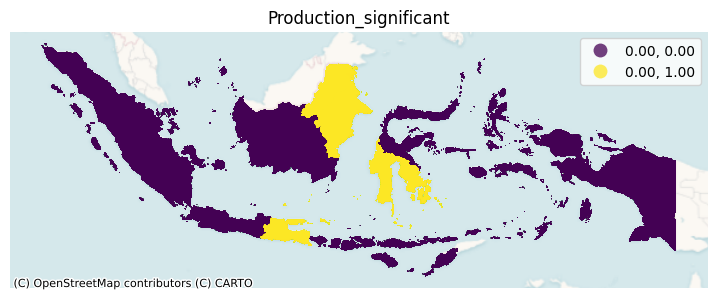

Memvisualisasikan X2 (Importation) ...


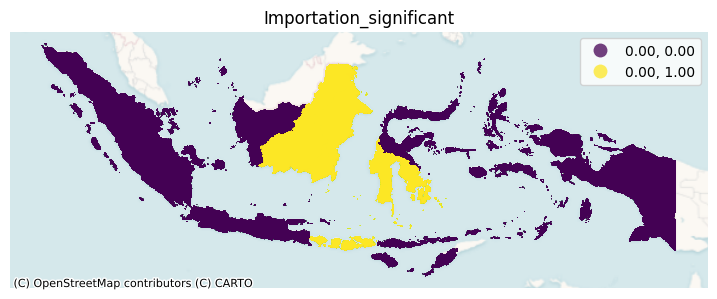

Memvisualisasikan X3 (Demand) ...


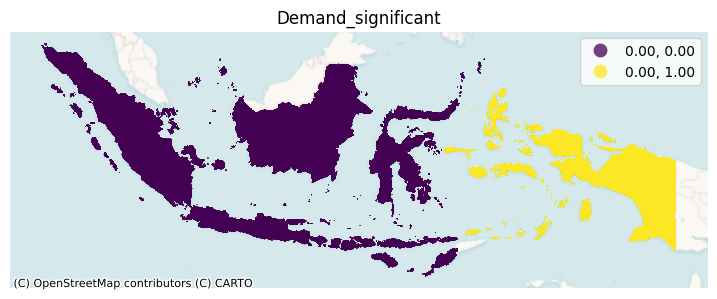

Memvisualisasikan X4 (Supply) ...


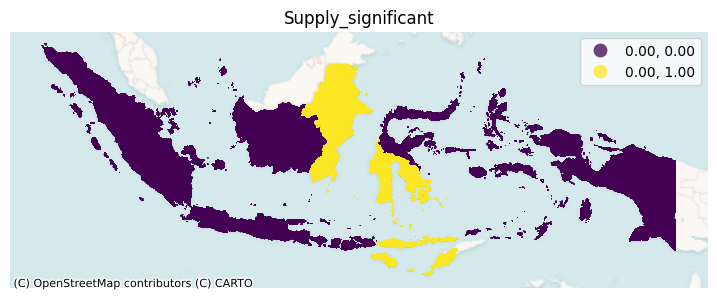

Memvisualisasikan X5 (Population) ...


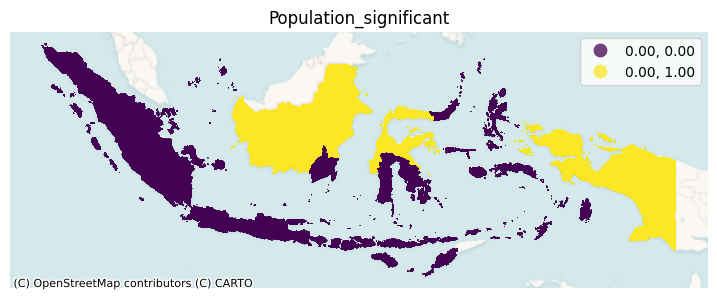

Memvisualisasikan X6 (Religious Holiday) ...


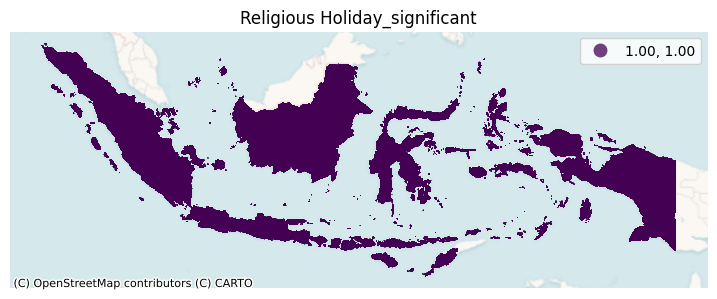

In [46]:
df_bi_fal, ev_bi_fal = run_gwr(datas_panel, features, target, kernel='bisquare', fixed=False)

## 2) BISQUARE - TRUE 

Mencari bandwidth optimal...


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.48229e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=7.48229e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.53162e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.53231e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.53231e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

Bandwidth optimal: 72.8
GWR fitting selesai.
Shape koefisien: (4080, 7)

--- ANALISIS P-VALUE < 0.05 ---
Fitur 'Production': 0 titik signifikan (p < 0.05)
Fitur 'Importation': 0 titik signifikan (p < 0.05)
Fitur 'Demand': 0 titik signifikan (p < 0.05)
Fitur 'Supply': 0 titik signifikan (p < 0.05)
Fitur 'Population': 0 titik signifikan (p < 0.05)
Fitur 'Religious Holiday': 4080 titik signifikan (p < 0.05)

--- PERSAMAAN REGRESI PER PROVINSI ---
Region Aceh: y = -0.0442 + 0.0908*x6
x6_sign: 1.0000

Region Bali: y = -0.0089 + 0.0917*x6
x6_sign: 1.0000

Region Bangka-Belitung: y = -0.0249 + 0.0913*x6
x6_sign: 1.0000

Region Banten: y = -0.0253 + 0.0909*x6
x6_sign: 1.0000

Region Bengkulu: y = -0.0325 + 0.0908*x6
x6_sign: 1.0000

Region Gorontalo: y = 0.0032 + 0.0931*x6
x6_sign: 1.0000

Region Jakarta Raya: y = -0.0240 + 0.0910*x6
x6_sign: 1.0000

Region Jambi: y = -0.0320 + 0.0910*x6
x6_sign: 1.0000

Region Jawa Barat: y = -0.0226 + 0.0911*x6
x6_sign: 1.0000

Region Jawa Tengah: y = -0.017

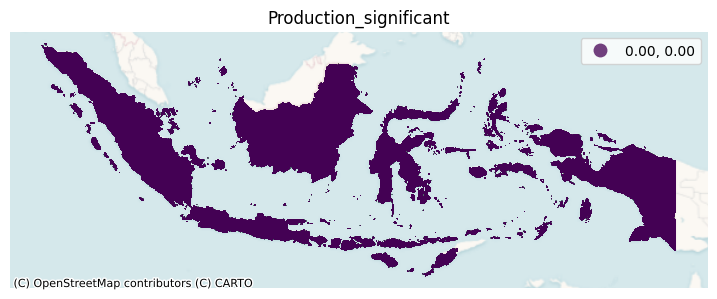

Memvisualisasikan X2 (Importation) ...


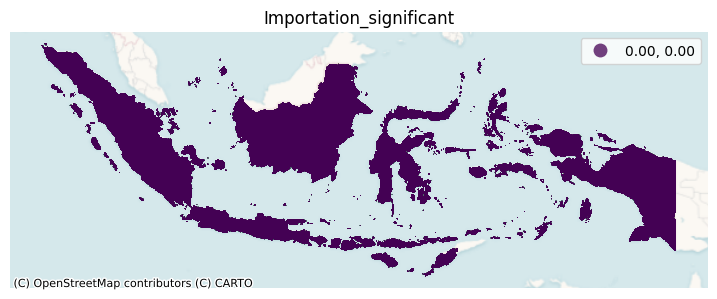

Memvisualisasikan X3 (Demand) ...


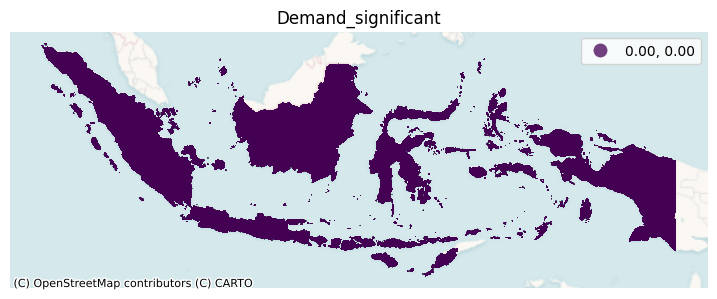

Memvisualisasikan X4 (Supply) ...


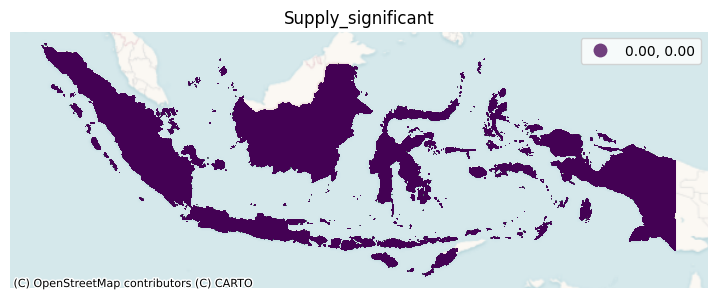

Memvisualisasikan X5 (Population) ...


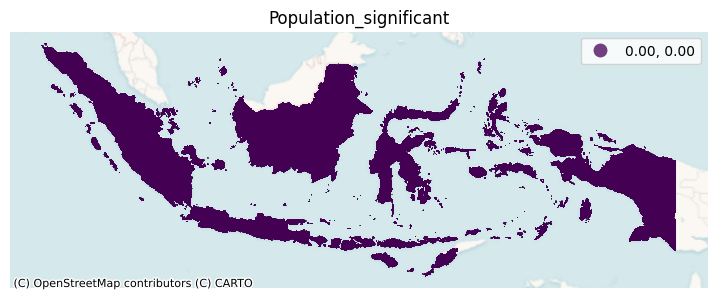

Memvisualisasikan X6 (Religious Holiday) ...


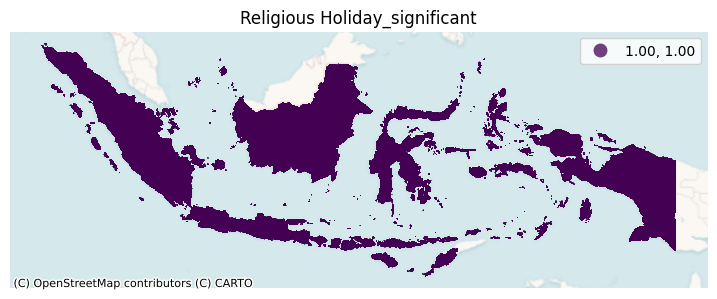

In [47]:
df_bi_true, ev_bi_true = run_gwr(datas_panel, features, target, kernel='bisquare', fixed=True)

## 3) GAUSSIAN - FALSE

Mencari bandwidth optimal...


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.12529e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.12529e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.70422e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.70422e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.70422e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

Bandwidth optimal: 140.0


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.56275e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.56275e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.56275e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.87142e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.87142e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

GWR fitting selesai.
Shape koefisien: (4080, 7)

--- ANALISIS P-VALUE < 0.05 ---
Fitur 'Production': 360 titik signifikan (p < 0.05)
Fitur 'Importation': 240 titik signifikan (p < 0.05)
Fitur 'Demand': 240 titik signifikan (p < 0.05)
Fitur 'Supply': 360 titik signifikan (p < 0.05)
Fitur 'Population': 960 titik signifikan (p < 0.05)
Fitur 'Religious Holiday': 1800 titik signifikan (p < 0.05)

--- PERSAMAAN REGRESI PER PROVINSI ---
Region Aceh: y = 0.1030 + -0.6463*x5
x5_sign: 1.0000

Region Bali: y = -0.2085 + 0.0928*x6
x6_sign: 1.0000

Region Bangka-Belitung: y = -0.2028 + 0.0625*x6
x6_sign: 1.0000

Region Banten: y = -0.2288


Region Bengkulu: y = -0.2350


Region Gorontalo: y = -0.0292


Region Jakarta Raya: y = -0.2447


Region Jambi: y = -0.2031 + 0.0775*x6
x6_sign: 1.0000

Region Jawa Barat: y = -0.2504


Region Jawa Tengah: y = -0.1444 + 0.1802*x5
x5_sign: 1.0000

Region Jawa Timur: y = -0.2698 + 0.0819*x6
x6_sign: 1.0000

Region Kalimantan Barat: y = -0.1610 + 0.1859*x5 + 0.0905

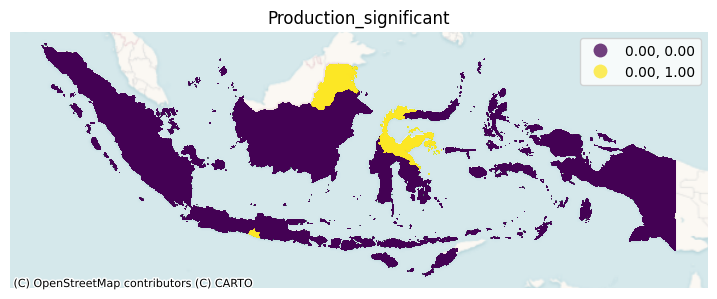

Memvisualisasikan X2 (Importation) ...


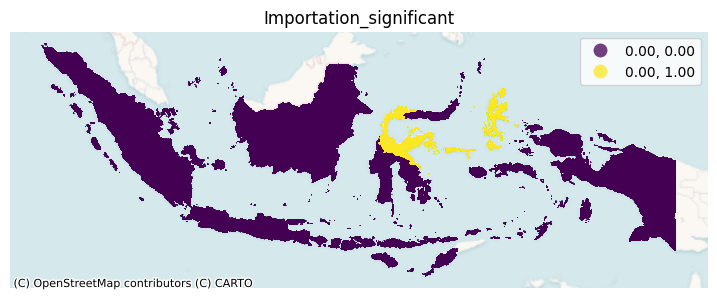

Memvisualisasikan X3 (Demand) ...


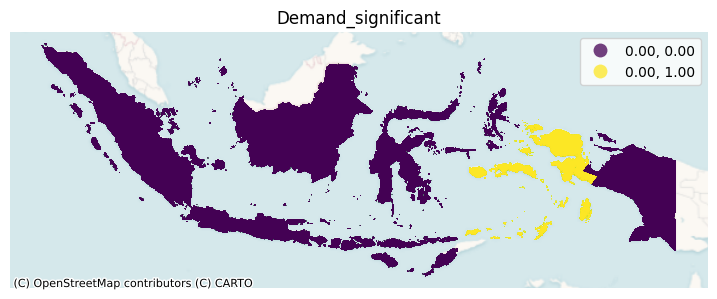

Memvisualisasikan X4 (Supply) ...


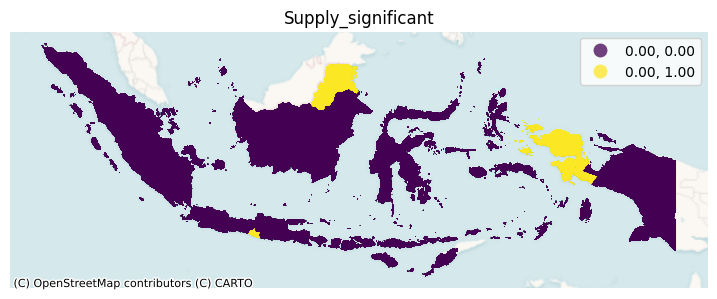

Memvisualisasikan X5 (Population) ...


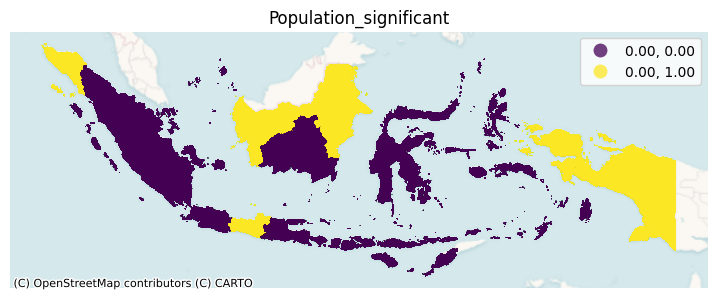

Memvisualisasikan X6 (Religious Holiday) ...


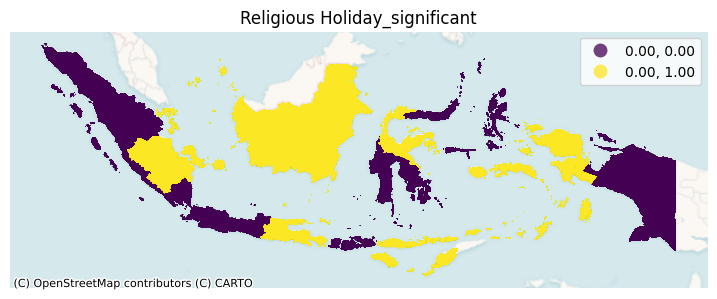

In [48]:
df_ga_fal, ev_ga_fal= run_gwr(datas_panel, features, target, kernel='gaussian', fixed=False)

## 4) GAUSSIAN - TRUE

Mencari bandwidth optimal...


/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.31241e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.29275e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=3.29275e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=5.31241e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.83275e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/usr/local/lib/python3.11/dist-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned m

Bandwidth optimal: 40.62
GWR fitting selesai.
Shape koefisien: (4080, 7)

--- ANALISIS P-VALUE < 0.05 ---
Fitur 'Production': 0 titik signifikan (p < 0.05)
Fitur 'Importation': 0 titik signifikan (p < 0.05)
Fitur 'Demand': 0 titik signifikan (p < 0.05)
Fitur 'Supply': 0 titik signifikan (p < 0.05)
Fitur 'Population': 0 titik signifikan (p < 0.05)
Fitur 'Religious Holiday': 4080 titik signifikan (p < 0.05)

--- PERSAMAAN REGRESI PER PROVINSI ---
Region Aceh: y = -0.0316 + 0.0910*x6
x6_sign: 1.0000

Region Bali: y = -0.0068 + 0.0917*x6
x6_sign: 1.0000

Region Bangka-Belitung: y = -0.0189 + 0.0914*x6
x6_sign: 1.0000

Region Banten: y = -0.0191 + 0.0911*x6
x6_sign: 1.0000

Region Bengkulu: y = -0.0242 + 0.0910*x6
x6_sign: 1.0000

Region Gorontalo: y = 0.0025 + 0.0928*x6
x6_sign: 1.0000

Region Jakarta Raya: y = -0.0182 + 0.0912*x6
x6_sign: 1.0000

Region Jambi: y = -0.0239 + 0.0911*x6
x6_sign: 1.0000

Region Jawa Barat: y = -0.0171 + 0.0912*x6
x6_sign: 1.0000

Region Jawa Tengah: y = -0.01

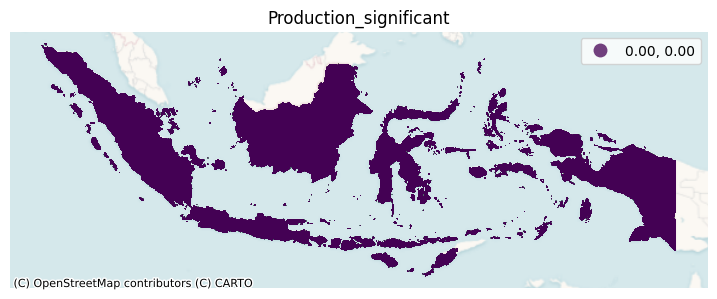

Memvisualisasikan X2 (Importation) ...


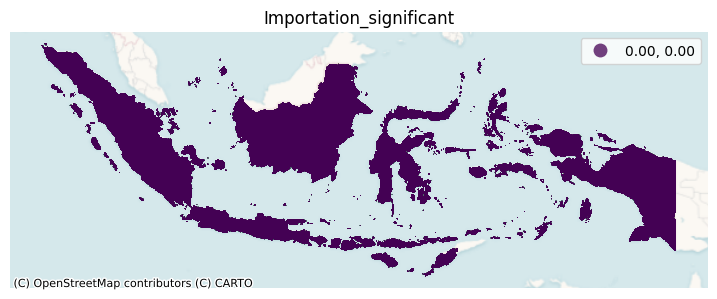

Memvisualisasikan X3 (Demand) ...


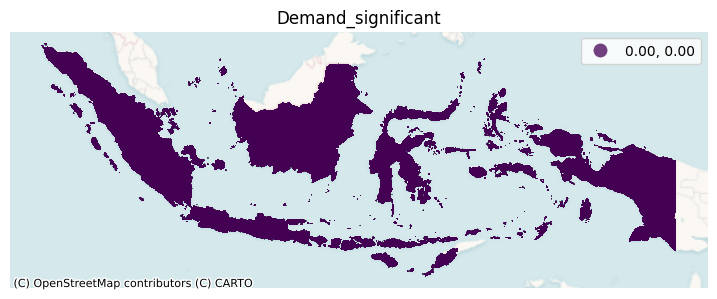

Memvisualisasikan X4 (Supply) ...


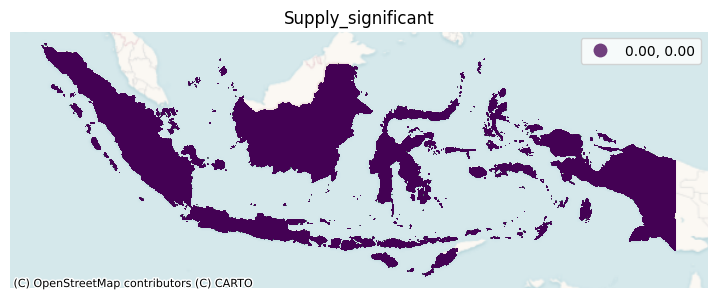

Memvisualisasikan X5 (Population) ...


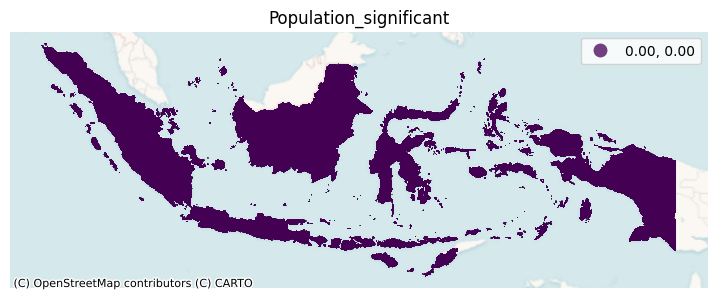

Memvisualisasikan X6 (Religious Holiday) ...


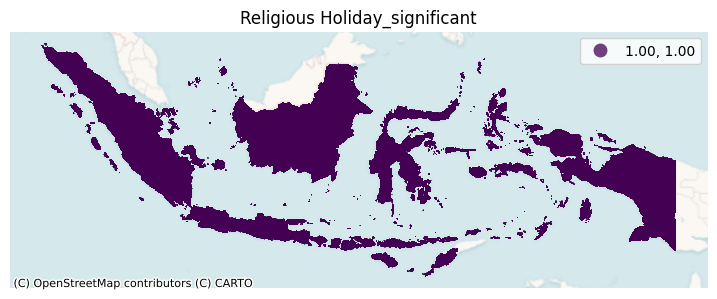

In [49]:
df_ga_true, ev_ga_true = run_gwr(datas_panel, features, target, kernel='gaussian', fixed=True)

## PERFORMA GWPR

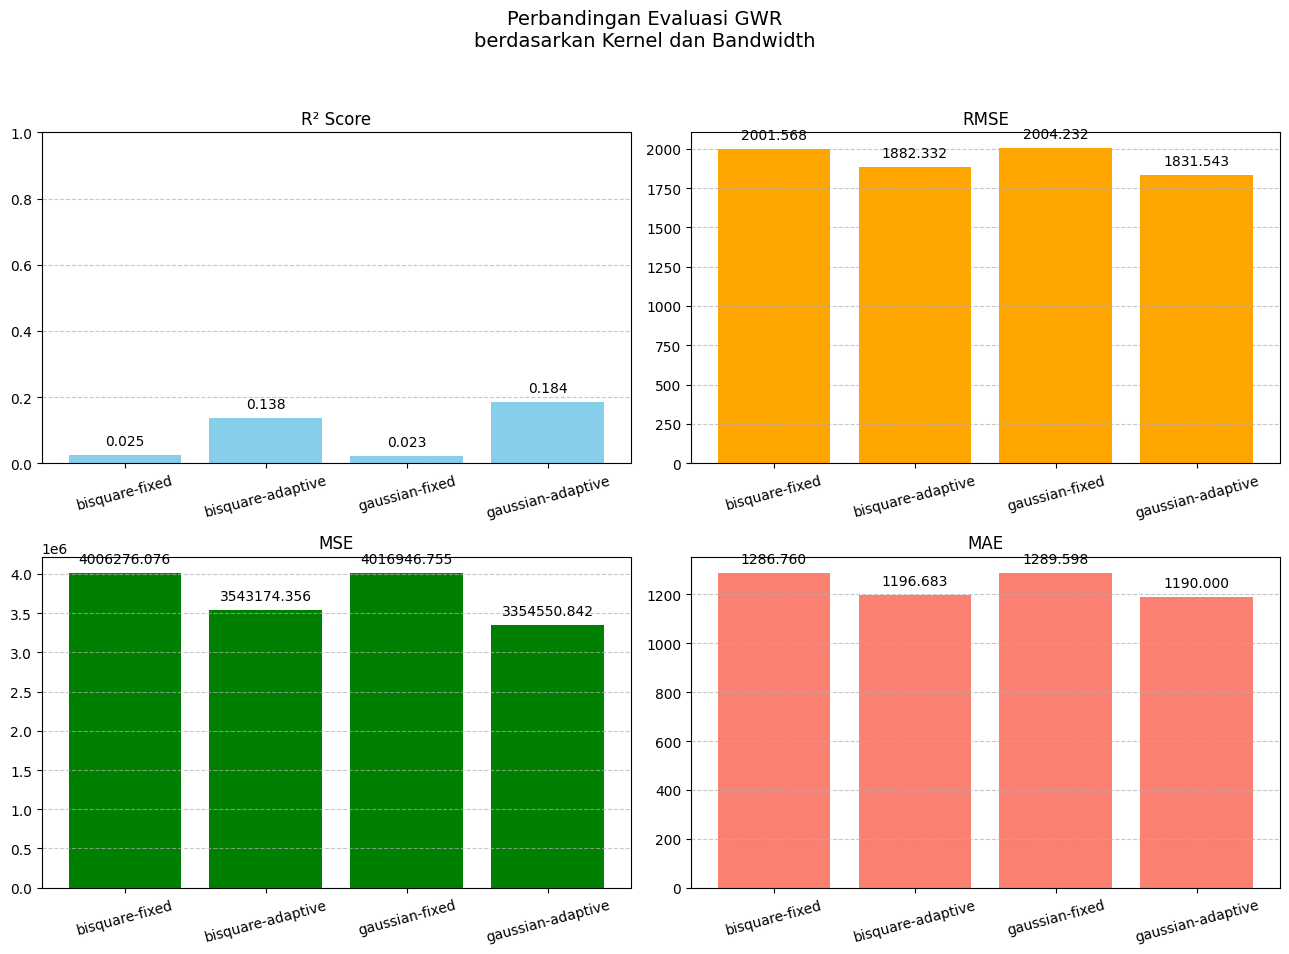

In [50]:
import matplotlib.pyplot as plt

# Data evaluasi dari 4 konfigurasi model
evals = [ev_bi_true, ev_bi_fal, ev_ga_true, ev_ga_fal]
labels = ['bisquare-fixed', 'bisquare-adaptive', 'gaussian-fixed', 'gaussian-adaptive']

# Ambil nilai evaluasi
r2_values = [ev['r2'] for ev in evals]
rmse_values = [ev['rmse'] for ev in evals]
mse_values = [ev['mse'] for ev in evals]
mae_values = [ev['mae'] for ev in evals]

# Plot subplot 2x2
fig, axs = plt.subplots(2, 2, figsize=(13, 10))

# Fungsi untuk menambahkan angka di atas batang
def add_value_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',  # Format angka dengan dua desimal
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Offset dari batang
                    textcoords="offset points",
                    ha='center', va='bottom')

# R²
bars = axs[0, 0].bar(labels, r2_values, color='skyblue')
axs[0, 0].set_title('R² Score')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
add_value_labels(axs[0, 0], bars)

# RMSE
bars = axs[0, 1].bar(labels, rmse_values, color='orange')
axs[0, 1].set_title('RMSE')
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
add_value_labels(axs[0, 1], bars)

# MSE
bars = axs[1, 0].bar(labels, mse_values, color='green')
axs[1, 0].set_title('MSE')
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
add_value_labels(axs[1, 0], bars)

# MAE
bars = axs[1, 1].bar(labels, mae_values, color='salmon')
axs[1, 1].set_title('MAE')
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
add_value_labels(axs[1, 1], bars)

# Tata letak dan label
for ax in axs.flat:
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=15)

plt.suptitle('Perbandingan Evaluasi GWR\nberdasarkan Kernel dan Bandwidth', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [51]:
df_ga_fal 

Province  Year  Month  Production  Importation        Demand  \
0           Aceh  2013      1  0.00000000   0.00000000 3262.00000000   
1           Aceh  2013      1  0.00000000  16.02000000 3399.00000000   
2           Aceh  2013      1  0.00000000   0.00000000 2902.00000000   
3           Aceh  2013      1  0.00000000   0.00000000 2529.00000000   
4           Aceh  2013      1  0.00000000   0.00000000 4706.00000000   
...          ...   ...    ...         ...          ...           ...   
4075  Yogyakarta  2017     11  0.00000000   0.00000000 2663.00000000   
4076  Yogyakarta  2017     12  0.00000000   0.00000000 4297.00000000   
4077  Yogyakarta  2017     12  0.00000000   0.00000000 2670.00000000   
4078  Yogyakarta  2017     12  0.00000000   0.00000000 3180.00000000   
4079  Yogyakarta  2017     12  0.00000000   0.00000000 3724.00000000   

          Supply          Price  Population  Religious Holiday  ...  \
0     0.00000000 12500.00000000     4811100                  0  ...   
1    16.02000000 12000.00000000     4906800                  0  ...   
2     0.00000000 11000.00000000     5020000                  0  ...   
3     0.00000000 13000.00000000     5096200                  0  ...   
4     0.00000000 14500.00000000     5189500                  0  ...   
...          ...            ...         ...                ...  ...   
4075  0.00000000 13239.00000000     3762200                  0  ...   
4076  0.00000000 12424.00000000     3762200                  1  ...   
4077  0.00000000 12500.00000000     3762200                  1  ...   
4078  0.00000000 12500.00000000     3762200                  1  ...   
4079  0.00000000 13386.00000000     3762200                  1  ...   

      Demand_significant Supply_pvalue Supply_significant  Population_pvalue  \
0                      0    0.98425759                  0         0.01816600   
1                      0    0.98425759                  0         0.01816600   
2                      0    0.98425759                  0         0.01816600   
3                      0    0.98425759                  0         0.01816600   
4                      0    0.98425759                  0         0.01816600   
...                  ...           ...                ...                ...   
4075                   0    0.02518017                  1         0.01392311   
4076                   0    0.02518017                  1         0.01392311   
4077                   0    0.02518017                  1         0.01392311   
4078                   0    0.02518017                  1         0.01392311   
4079                   0    0.02518017                  1         0.01392311   

      Population_significant  Religious Holiday_pvalue  \
0                          1                0.24677616   
1                          1                0.24677616   
2                          1                0.24677616   
3                          1                0.24677616   
4                          1                0.24677616   
...                      ...                       ...   
4075                       1                0.27026816   
4076                       1                0.27026816   
4077                       1                0.27026816   
4078                       1                0.27026816   
4079                       1                0.27026816   

      Religious Holiday_significant         Actual      Predicted  \
0                                 0 12500.00000000 13326.30861594   
1                                 0 12000.00000000 13371.30026982   
2                                 0 11000.00000000 13295.98723178   
3                                 0 13000.00000000 13281.71031322   
4                                 0 14500.00000000 13299.28243518   
...                             ...            ...            ...   
4075                              0 13239.00000000 12200.07029257   
4076                              0 12424.00000000 12544.18716837   
4077       

In [52]:
df_ga_fal.to_excel('hasil_gwpr_gaussian_false.xlsx')

# DATASET FIX FROM GWPR

In [ ]:
df_fix = df_ga_fal.copy()
df_fix

In [ ]:
df_fix = df_fix.drop(['geometry', 'centroid', 'lon', 'lat'],axis=1)
df_fix

# CREATE MULTISTEPS DATA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

def create_sequence(X, Y, lookback, step):
    X_sequences = []  
    Y_sequences = []
    for i in range(len(X) - lookback - step + 1):
        X_seq = X[i:i+lookback]
        Y_seq = Y[i+lookback:i+lookback+step]
        X_sequences.append(X_seq)
        Y_sequences.append(Y_seq)
    return np.array(X_sequences), np.array(Y_sequences)

def multi_step_target(Xx, Yy, step, lookback, kfold):
    X_train_fold = {i:[] for i in range(kfold)}
    X_test_fold = {i:[] for i in range(kfold)}
    Y_train_fold = {i:[] for i in range(kfold)}
    Y_test_fold = {i:[] for i in range(kfold)}

    # Simpan semua scaler Y agar nanti bisa inverse_transform
    scalers_y = {i: [] for i in range(kfold)}

    tscv = TimeSeriesSplit(n_splits=kfold)

    for name, group in Yy.groupby(level='Province'):
        dataset_X = np.array(Xx[Xx.index.get_level_values('Province') == name].reset_index(drop=True))
        dataset_Y = np.array(Yy[Yy.index.get_level_values('Province') == name].reset_index(drop=True))

        for fold, (train_idx, test_idx) in enumerate(tscv.split(dataset_X)):
            # Bagi data
            X_train, X_test = dataset_X[train_idx], dataset_X[test_idx]
            y_train, y_test = dataset_Y[train_idx], dataset_Y[test_idx]

            # Standarisasi X
            scaler_x = StandardScaler()
            X_train_scaled = scaler_x.fit_transform(X_train)
            X_test_scaled = scaler_x.transform(X_test)

            # Standarisasi Y
            scaler_y = StandardScaler()
            y_train_scaled = scaler_y.fit_transform(y_train)
            y_test_scaled = scaler_y.transform(y_test)

            # Simpan scaler_y untuk inverse_transform nanti
            scalers_y[fold].append(scaler_y)

            # Buat urutan
            X_seq_train, Y_seq_train = create_sequence(X_train_scaled, y_train_scaled, lookback, step)
            X_seq_test, Y_seq_test = create_sequence(X_test_scaled, y_test_scaled, lookback, step)

            X_train_fold[fold].append(X_seq_train)
            Y_train_fold[fold].append(Y_seq_train)
            X_test_fold[fold].append(X_seq_test)
            Y_test_fold[fold].append(Y_seq_test)

    for i in range(kfold):
        X_train_fold[i] = np.array(X_train_fold[i])
        X_train_fold[i] = X_train_fold[i].reshape(-1, X_train_fold[i].shape[2], X_train_fold[i].shape[3])

        X_test_fold[i] = np.array(X_test_fold[i])
        X_test_fold[i] = X_test_fold[i].reshape(-1, X_test_fold[i].shape[2], X_test_fold[i].shape[3])

        Y_train_fold[i] = np.array(Y_train_fold[i])
        Y_train_fold[i] = Y_train_fold[i].reshape(-1, Y_train_fold[i].shape[2])

        Y_test_fold[i] = np.array(Y_test_fold[i])
        Y_test_fold[i] = Y_test_fold[i].reshape(-1, Y_test_fold[i].shape[2])

    return X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, scalers_y


In [ ]:
import pandas as pd

# Salin dataframe
data = df_fix.copy()

# Pastikan kolom 'Province', 'Year', dan 'Month' digunakan sebagai MultiIndex
data.set_index(['Province', 'Year', 'Month'], inplace=True)

# Buang kolom 'Actual' dari fitur jika masih ada
data.drop(columns=['Price'], inplace=True, errors='ignore')

# Misalnya kamu ingin target 'Actual' tetap disimpan sebelumnya
# Maka simpan target 'Actual' dahulu sebelum drop
target = df_fix.set_index(['Province', 'Year', 'Month'])[['Price']]

# Pisahkan fitur (Xx) dan target (Yy)
Xx = data  # Semua fitur (tanpa kolom 'Actual')
Yy = target  # Target (kolom 'Actual') dengan multiindex

# Optional: pastikan indeksnya sudah sesuai
print("Contoh MultiIndex fitur:")
print(Xx.index.names)

print("Contoh MultiIndex target:")
print(Yy.index.names)


# FOWARD CHAINING FOLD

In [ ]:
lookback = 12    # panjang sequence input
step = 4        # panjang horizon output (multi-step)
kfold = 5       # jumlah fold time series split

In [ ]:
X_train_fold, X_test_fold, Y_train_fold, Y_test_fold, scaler_y = multi_step_target(Xx, Yy, step, lookback, kfold)

# Menampilkan bentuk X dan Y hasil pemrosesan untuk verifikasi
for i in range(kfold):
    print(f"Bentuk X_train fold-{i}:", X_train_fold[i].shape)
    print(f"Bentuk Y_train fold-{i}:", Y_train_fold[i].shape)
    print(f"Bentuk X_test fold-{i}:", X_test_fold[i].shape)
    print(f"Bentuk Y_test fold-{i}:", Y_test_fold[i].shape)
    print('-'*40)

In [ ]:
import matplotlib.pyplot as plt

train_counts = [len(X_train_fold[i]) for i in range(kfold)]
test_counts = [len(X_test_fold[i]) for i in range(kfold)]

folds = list(range(kfold))
bar_height = 0.35
fig, ax = plt.subplots(figsize=(10, 6))

train_bar = ax.barh([f - bar_height/2 for f in folds], train_counts, bar_height, label='Train')
test_bar = ax.barh([f + bar_height/2 for f in folds], test_counts, bar_height, label='Test')

ax.set_ylabel('Fold')
ax.set_xlabel('Jumlah Sample (setelah sequencing)')
ax.set_title('Distribusi Train dan Test per Fold untuk semua provinsi')
ax.set_yticks(folds)
ax.set_yticklabels([f'Fold {i}' for i in folds])
ax.legend(loc='lower right')

# Tambahkan label
for bar in train_bar + test_bar:
    width = bar.get_width()
    ax.annotate(f'{width}',
                xy=(width, bar.get_y() + bar.get_height() / 2),
                xytext=(3, 0),
                textcoords="offset points",
                ha='left', va='center')

plt.tight_layout()
plt.show()


In [ ]:
!pip install --upgrade statsmodels


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

# Definisikan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',      # Pantau validasi loss
    patience=15,              # Tunggu 5 epoch tanpa perbaikan
    restore_best_weights=True # Kembalikan bobot terbaik saat selesai training
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Pantau validasi loss
    factor=0.5,              # Kurangi lr jadi setengahnya
    patience=5,              # Tunggu 3 epoch tanpa perbaikan

)

def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    
    model.add(Dense(output_size))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model

def arima_forecast_fold(y_train, step):
    y_series = y_train.flatten()  # 1D
    model = sm.tsa.ARIMA(y_series, order=(1,1,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=step)  # forecast = (step,)
    return forecast

def sarimax_forecast_fold(y_train, step):
    y_series = y_train.flatten()
    model = SARIMAX(y_series, order=(1,1,1), seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=step)
    return forecast

def ensemble_forecast(lstm_preds, arima_preds, provinces, step):
    ensembled = []
    for i, prov in enumerate(provinces):
        lstm_pred = lstm_preds[i]
        arima_pred = np.array(arima_preds[prov])
        avg_pred = (lstm_pred + arima_pred) / 2
        ensembled.append(avg_pred)
    return np.array(ensembled)

def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Hindari div by 0

    return mse, rmse, mae, mape


# STANDALONE MODELS

##  ARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi ARIMA saja
    arima_preds = arima_forecast_fold(Y_train, step)
    arima_preds_broadcasted = np.tile(arima_preds, (Y_test.shape[0], 1))

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    arima_preds_orig = scaler_target.inverse_transform(arima_preds_broadcasted)

    # Evaluasi hasil prediksi ARIMA
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, arima_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), arima_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_arima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_arima)


## SARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi ARIMA saja
    sarimax_preds = sarimax_forecast_fold(Y_train, step)
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (Y_test.shape[0], 1))

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    sarimax_preds_orig = scaler_target.inverse_transform(sarimax_preds_broadcasted)

    # Evaluasi hasil prediksi ARIMA
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, sarimax_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), sarimax_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_sarima)


## ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true + 1e-8)) * 100  # tambahkan epsilon utk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]  # shape: (n_samples, lookback, n_features)
    Y_train = Y_train_fold[fold]  # shape: (n_samples, step)
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    n_samples, lookback, n_features = X_train.shape
    step = Y_train.shape[1]

    # Reshape data untuk AdaBoost: (samples, features)
    X_train_reshaped = X_train.reshape(n_samples, lookback * n_features)
    X_test_reshaped = X_test.reshape(X_test.shape[0], lookback * n_features)

    # Karena AdaBoost tidak support multivariate output langsung, kita buat model per langkah ke depan
    preds_list = []
    for i in range(step):
        model = AdaBoostRegressor(n_estimators=50, random_state=42)
        model.fit(X_train_reshaped, Y_train[:, i])
        preds = model.predict(X_test_reshaped)
        preds_list.append(preds)

    # Gabungkan prediksi ke array 2D: (n_samples, step)
    adaboost_preds = np.column_stack(preds_list)

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    adaboost_preds_orig = scaler_target.inverse_transform(adaboost_preds)

    # Evaluasi hasil prediksi AdaBoost
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, adaboost_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), adaboost_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_adaboost = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_adaboost)


## EXTRATREES REGRESSOR 

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]  # shape: (n_samples, lookback, n_features)
    Y_train = Y_train_fold[fold]  # shape: (n_samples, step)
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    n_samples, lookback, n_features = X_train.shape
    step = Y_train.shape[1]

    # Reshape data untuk ExtraTrees: (samples, features)
    X_train_reshaped = X_train.reshape(n_samples, lookback * n_features)
    X_test_reshaped = X_test.reshape(X_test.shape[0], lookback * n_features)

    # Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
    preds_list = []
    for i in range(step):
        model = ExtraTreesRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_reshaped, Y_train[:, i])
        preds = model.predict(X_test_reshaped)
        preds_list.append(preds)

    # Gabungkan prediksi ke array 2D: (n_samples, step)
    extratrees_preds = np.column_stack(preds_list)

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    extratrees_preds_orig = scaler_target.inverse_transform(extratrees_preds)

    # Evaluasi hasil prediksi ExtraTrees
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, extratrees_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), extratrees_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_extratrees = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_extratrees)


## GRADIENT BOOSTING

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]  # shape: (n_samples, lookback, n_features)
    Y_train = Y_train_fold[fold]  # shape: (n_samples, step)
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    n_samples, lookback, n_features = X_train.shape
    step = Y_train.shape[1]

    # Reshape data untuk GradientBoosting: (samples, features)
    X_train_reshaped = X_train.reshape(n_samples, lookback * n_features)
    X_test_reshaped = X_test.reshape(X_test.shape[0], lookback * n_features)

    # Karena GradientBoostingRegressor tidak support multivariate output langsung, buat model per langkah ke depan
    preds_list = []
    for i in range(step):
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_reshaped, Y_train[:, i])
        preds = model.predict(X_test_reshaped)
        preds_list.append(preds)

    # Gabungkan prediksi ke array 2D: (n_samples, step)
    gbr_preds = np.column_stack(preds_list)

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    gbr_preds_orig = scaler_target.inverse_transform(gbr_preds)

    # Evaluasi hasil prediksi GradientBoosting
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, gbr_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), gbr_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_gbr = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_gbr)


## RANDOM FOREST

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]  # shape: (n_samples, lookback, n_features)
    Y_train = Y_train_fold[fold]  # shape: (n_samples, step)
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    n_samples, lookback, n_features = X_train.shape
    step = Y_train.shape[1]

    # Reshape data untuk RandomForest: (samples, features)
    X_train_reshaped = X_train.reshape(n_samples, lookback * n_features)
    X_test_reshaped = X_test.reshape(X_test.shape[0], lookback * n_features)

    # Karena RandomForestRegressor tidak support multivariate output langsung, buat model per langkah ke depan
    preds_list = []
    for i in range(step):
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train_reshaped, Y_train[:, i])
        preds = model.predict(X_test_reshaped)
        preds_list.append(preds)

    # Gabungkan prediksi ke array 2D: (n_samples, step)
    rf_preds = np.column_stack(preds_list)

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    rf_preds_orig = scaler_target.inverse_transform(rf_preds)

    # Evaluasi hasil prediksi RandomForest
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, rf_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), rf_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_rf = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_rf)


## LSTM 

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (lookback, num_features)
    output_size = Y_train.shape[1]  # step

    # Train LSTM
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)

    # Prediksi dengan LSTM
    lstm_preds = lstm_model.predict(X_test)  # shape (n_samples, step)

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # hanya pakai scaler_y dari provinsi pertama di fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    lstm_preds_orig = scaler_target.inverse_transform(lstm_preds)

    # Evaluasi hasil prediksi LSTM
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, lstm_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), lstm_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_lstm = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_lstm)


# AEM - MODELS

## ARIMA SARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (lookback, num_features)
    output_size = Y_train.shape[1]  # step ke depan

    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi ARIMA
    arima_preds = arima_forecast_fold(Y_train, step)
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))

    # Prediksi SARIMAX
    sarimax_preds = sarimax_forecast_fold(Y_train, step)
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Ensemble rata-rata dari LSTM, ARIMA, dan SARIMAX
    final_preds = (lstm_preds + arima_preds_broadcasted + sarimax_preds_broadcasted) / 3

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    final_preds_orig = scaler_target.inverse_transform(final_preds)

    # Evaluasi hasil ensemble
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, final_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), final_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_AEM_arima_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_AEM_arima_sarima)

## LSTM + ARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list,  rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (lookback, num_features)
    output_size = Y_train.shape[1]  # step

    # Train LSTM
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)

    # Prediksi dengan LSTM
    lstm_preds = lstm_model.predict(X_test)  # shape (n_samples, step)
    
    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi ARIMA
    arima_preds = arima_forecast_fold(Y_train, step)
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))

    # Ensemble rata-rata
    final_preds = (lstm_preds + arima_preds_broadcasted) / 2

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # hanya pakai scaler_y dari provinsi pertama di fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    final_preds_orig = scaler_target.inverse_transform(final_preds)

    # Evaluasi hasil ensemble
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, final_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), final_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_AEM_lstm_arima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_AEM_lstm_arima)


## LSTM + SARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (lookback, num_features)
    output_size = Y_train.shape[1]  # step

    # Train LSTM
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)

    # Prediksi dengan LSTM
    lstm_preds = lstm_model.predict(X_test)  # shape (n_samples, step)
    
    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi SARIMAX
    sarimax_preds = sarimax_forecast_fold(Y_train, step)
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Ensemble rata-rata
    final_preds = (lstm_preds + sarimax_preds_broadcasted) / 2

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # hanya pakai scaler_y dari provinsi pertama di fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    final_preds_orig = scaler_target.inverse_transform(final_preds)

    # Evaluasi hasil ensemble
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, final_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), final_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_AEM_lstm_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_AEM_lstm_sarima)


## LSTM + ARIMA + SARIMA

In [ ]:
# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")
    
    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])  # (lookback, num_features)
    output_size = Y_train.shape[1]  # step ke depan

    # Train LSTM
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)

    # Prediksi dengan LSTM
    lstm_preds = lstm_model.predict(X_test)  # shape (n_samples, step)

    step = Y_train.shape[1]  # jumlah langkah ke depan

    # Prediksi ARIMA
    arima_preds = arima_forecast_fold(Y_train, step)
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))

    # Prediksi SARIMAX
    sarimax_preds = sarimax_forecast_fold(Y_train, step)
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Ensemble rata-rata dari LSTM, ARIMA, dan SARIMAX
    final_preds = (lstm_preds + arima_preds_broadcasted + sarimax_preds_broadcasted) / 3

    # === Inverse transform sebelum evaluasi ===
    scaler_target = scaler_y[fold][0]  # pakai scaler_y dari provinsi pertama fold ini
    Y_test_orig = scaler_target.inverse_transform(Y_test)
    final_preds_orig = scaler_target.inverse_transform(final_preds)

    # Evaluasi hasil ensemble
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, final_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), final_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_AEM_lstm_arima_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_AEM_lstm_arima_sarima)

# MLP - MODELS

## ARIMA SARIMA (MLP)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Fungsi evaluasi (tambahkan mse)
def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Hindari div by 0

    return mse, rmse, mae, mape

# Fungsi buat MLP meta learner
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

# -------------------------
# LOOP K-FOLD TRAINING
# -------------------------

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")

    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_size = Y_train.shape[1]

    # # TRAIN LSTM MODEL
    # lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)
    # lstm_preds = lstm_model.predict(X_test)  # (n_samples, steps)

    step = Y_train.shape[1]

    # PREDIKSI ARIMA dan SARIMAX untuk fold ini
    arima_preds = arima_forecast_fold(Y_train, step)  # shape (steps,)
    sarimax_preds = sarimax_forecast_fold(Y_train, step)  # shape (steps,)

    # Broadcast ke setiap sample pada test set
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Siapkan fitur meta learner dengan gabung ketiga prediksi
    X_meta_train = np.hstack([
        # lstm_preds.reshape(lstm_preds.shape[0], -1),
        arima_preds_broadcasted.reshape(arima_preds_broadcasted.shape[0], -1),
        sarimax_preds_broadcasted.reshape(sarimax_preds_broadcasted.shape[0], -1)
    ])

    # Target meta learner juga dalam bentuk 2D (samples, steps)
    y_meta_train = Y_test.reshape(Y_test.shape[0], -1)

    # TRAIN MLP META LEARNER & PREDIKSI
    mlp_model, mlp_preds = train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_train, epochs=50, batch_size=32)

    print('mlp_preds shape:', mlp_preds.shape)
    print('Y_test shape:', Y_test.shape)

    # Inverse transform ke nilai asli
    scaler_target = scaler_y[fold][0]
    Y_test_orig = scaler_target.inverse_transform(Y_test.reshape(-1, step)).reshape(Y_test.shape)
    mlp_preds_orig = scaler_target.inverse_transform(mlp_preds).reshape(mlp_preds.shape)

    # Evaluasi hasil meta learner MLP
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, mlp_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), mlp_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dataframe hasil evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_MLP_arima_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_MLP_arima_sarima)


## LSTM + ARIMA (MLP)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Fungsi evaluasi (tambahkan mse)
def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Hindari div by 0

    return mse, rmse, mae, mape

# Fungsi buat MLP meta learner
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

# -------------------------
# LOOP K-FOLD TRAINING
# -------------------------

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")

    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_size = Y_train.shape[1]

    # TRAIN LSTM MODEL
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)
    lstm_preds = lstm_model.predict(X_test)  # (n_samples, steps)

    step = Y_train.shape[1]

    # PREDIKSI ARIMA dan SARIMAX untuk fold ini
    arima_preds = arima_forecast_fold(Y_train, step)  # shape (steps,)
    sarimax_preds = sarimax_forecast_fold(Y_train, step)  # shape (steps,)

    # Broadcast ke setiap sample pada test set
    # arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))
    # sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Siapkan fitur meta learner dengan gabung ketiga prediksi
    X_meta_train = np.hstack([
        lstm_preds.reshape(lstm_preds.shape[0], -1),
        arima_preds_broadcasted.reshape(arima_preds_broadcasted.shape[0], -1),
        # sarimax_preds_broadcasted.reshape(sarimax_preds_broadcasted.shape[0], -1)
    ])

    # Target meta learner juga dalam bentuk 2D (samples, steps)
    y_meta_train = Y_test.reshape(Y_test.shape[0], -1)

    # TRAIN MLP META LEARNER & PREDIKSI
    mlp_model, mlp_preds = train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_train, epochs=50, batch_size=32)

    print('mlp_preds shape:', mlp_preds.shape)
    print('Y_test shape:', Y_test.shape)

    # Inverse transform ke nilai asli
    scaler_target = scaler_y[fold][0]
    Y_test_orig = scaler_target.inverse_transform(Y_test.reshape(-1, step)).reshape(Y_test.shape)
    mlp_preds_orig = scaler_target.inverse_transform(mlp_preds).reshape(mlp_preds.shape)

    # Evaluasi hasil meta learner MLP
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, mlp_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), mlp_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dataframe hasil evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_MLP_lstm_arima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_MLP_lstm_arima)


## LSTM + SARIMA (MLP)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Fungsi evaluasi (tambahkan mse)
def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Hindari div by 0

    return mse, rmse, mae, mape

# Fungsi buat MLP meta learner
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

# -------------------------
# LOOP K-FOLD TRAINING
# -------------------------

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")

    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_size = Y_train.shape[1]

    # TRAIN LSTM MODEL
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)
    lstm_preds = lstm_model.predict(X_test)  # (n_samples, steps)

    step = Y_train.shape[1]

    # # PREDIKSI ARIMA dan SARIMAX untuk fold ini
    # arima_preds = arima_forecast_fold(Y_train, step)  # shape (steps,)
    # sarimax_preds = sarimax_forecast_fold(Y_train, step)  # shape (steps,)

    # Broadcast ke setiap sample pada test set
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Siapkan fitur meta learner dengan gabung ketiga prediksi
    X_meta_train = np.hstack([
        lstm_preds.reshape(lstm_preds.shape[0], -1),
        # arima_preds_broadcasted.reshape(arima_preds_broadcasted.shape[0], -1),
        sarimax_preds_broadcasted.reshape(sarimax_preds_broadcasted.shape[0], -1)
    ])

    # Target meta learner juga dalam bentuk 2D (samples, steps)
    y_meta_train = Y_test.reshape(Y_test.shape[0], -1)

    # TRAIN MLP META LEARNER & PREDIKSI
    mlp_model, mlp_preds = train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_train, epochs=50, batch_size=32)

    print('mlp_preds shape:', mlp_preds.shape)
    print('Y_test shape:', Y_test.shape)

    # Inverse transform ke nilai asli
    scaler_target = scaler_y[fold][0]
    Y_test_orig = scaler_target.inverse_transform(Y_test.reshape(-1, step)).reshape(Y_test.shape)
    mlp_preds_orig = scaler_target.inverse_transform(mlp_preds).reshape(mlp_preds.shape)

    # Evaluasi hasil meta learner MLP
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, mlp_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), mlp_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dataframe hasil evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_MLP_lstm_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_MLP_lstm_sarima)


## LSTM + ARIMA + SARIMA (MLP)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Fungsi evaluasi (tambahkan mse)
def evaluate_forecast(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Hindari div by 0

    return mse, rmse, mae, mape

# Fungsi buat MLP meta learner
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

# -------------------------
# LOOP K-FOLD TRAINING
# -------------------------

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

for fold in range(kfold):
    print(f"\n=== Fold {fold+1}/{kfold} ===")

    X_train = X_train_fold[fold]
    Y_train = Y_train_fold[fold]
    X_test = X_test_fold[fold]
    Y_test = Y_test_fold[fold]

    input_shape = (X_train.shape[1], X_train.shape[2])
    output_size = Y_train.shape[1]

    # TRAIN LSTM MODEL
    lstm_model = train_lstm_keras(X_train, Y_train, X_test, Y_test, input_shape, output_size, epochs=50, batch_size=64)
    lstm_preds = lstm_model.predict(X_test)  # (n_samples, steps)

    step = Y_train.shape[1]

    # PREDIKSI ARIMA dan SARIMAX untuk fold ini
    arima_preds = arima_forecast_fold(Y_train, step)  # shape (steps,)
    sarimax_preds = sarimax_forecast_fold(Y_train, step)  # shape (steps,)

    # Broadcast ke setiap sample pada test set
    arima_preds_broadcasted = np.tile(arima_preds, (lstm_preds.shape[0], 1))
    sarimax_preds_broadcasted = np.tile(sarimax_preds, (lstm_preds.shape[0], 1))

    # Siapkan fitur meta learner dengan gabung ketiga prediksi
    X_meta_train = np.hstack([
        lstm_preds.reshape(lstm_preds.shape[0], -1),
        arima_preds_broadcasted.reshape(arima_preds_broadcasted.shape[0], -1),
        sarimax_preds_broadcasted.reshape(sarimax_preds_broadcasted.shape[0], -1)
    ])

    # Target meta learner juga dalam bentuk 2D (samples, steps)
    y_meta_train = Y_test.reshape(Y_test.shape[0], -1)

    # TRAIN MLP META LEARNER & PREDIKSI
    mlp_model, mlp_preds = train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_train, epochs=50, batch_size=32)

    print('mlp_preds shape:', mlp_preds.shape)
    print('Y_test shape:', Y_test.shape)

    # Inverse transform ke nilai asli
    scaler_target = scaler_y[fold][0]
    Y_test_orig = scaler_target.inverse_transform(Y_test.reshape(-1, step)).reshape(Y_test.shape)
    mlp_preds_orig = scaler_target.inverse_transform(mlp_preds).reshape(mlp_preds.shape)

    # Evaluasi hasil meta learner MLP
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, mlp_preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), mlp_preds_orig.flatten())

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    mape_list.append(mape)
    r2_list.append(r2)

    print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dataframe hasil evaluasi
eval_summary = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_MLP_lstm_arima_sarima = pd.DataFrame(eval_summary)

print("\n=== RATA-RATA EVALUASI DALAM DATAFRAME ===")
print(df_MLP_lstm_arima_sarima)


# REKAP PERFORMA

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Semua model, gabungan dan standalone
models = [
    'arima', 'sarima', 'adaboost', 'extratress', 'gbr', 'rf', 'lstm',  # standalone
    'arima-sarima', 'lstm-arima', 'lstm-sarima', 'lstm-arima-sarima'   # gabungan
]

# Dictionary dataframe
df_standalone_dict = {
    'arima': df_arima,
    'sarima': df_sarima,
    'adaboost': df_adaboost,
    'extratress': df_extratrees,
    'gbr': df_gbr,
    'rf': df_rf,
    'lstm': df_lstm
}

df_AEM_dict = {
    'arima-sarima': df_AEM_arima_sarima,
    'lstm-arima': df_AEM_lstm_arima,
    'lstm-sarima': df_AEM_lstm_sarima,
    'lstm-arima-sarima': df_AEM_lstm_arima_sarima
}

df_MLP_dict = {
    'arima-sarima': df_MLP_arima_sarima,
    'lstm-arima': df_MLP_lstm_arima,
    'lstm-sarima': df_MLP_lstm_sarima,
    'lstm-arima-sarima': df_MLP_lstm_arima_sarima
}

metrics = ['Avg MSE', 'Avg RMSE', 'Avg MAE', 'Avg MAPE (%)', 'Avg R2']

data_long = []

for model in models:
    if model in df_AEM_dict:
        for metric in metrics:
            data_long.append({
                'Model': model,
                'Metric': metric,
                'Method': 'AEM',
                'Value': df_AEM_dict[model][metric].values[0]
            })
    if model in df_MLP_dict:
        for metric in metrics:
            data_long.append({
                'Model': model,
                'Metric': metric,
                'Method': 'MLP',
                'Value': df_MLP_dict[model][metric].values[0]
            })
    if model in df_standalone_dict:
        for metric in metrics:
            data_long.append({
                'Model': model,
                'Metric': metric,
                'Method': 'Standalone',
                'Value': df_standalone_dict[model][metric].values[0]
            })

df_plot = pd.DataFrame(data_long)

sns.set(style="whitegrid")
palette = sns.color_palette("Paired", n_colors=3)  # AEM, MLP, Standalone

for metric in metrics:
    plt.figure(figsize=(12,6))
    df_sub = df_plot[df_plot['Metric'] == metric]
    
    ax = sns.barplot(
        data=df_sub,
        x='Model',
        y='Value',
        hue='Method',
        palette=palette
    )
    
    # Tambahkan angka di atas tiap bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}',  # format 3 desimal
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=9,
                    xytext=(0, 3),
                    textcoords='offset points')
    
    plt.title(metric)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend(title='Method', loc='best', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#Split Data

In [ ]:
# def build_plotmap(dbs, column):
#     # Set up figure and a single axis
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     # Build choropleth
#     dbs.plot(
#         column=column,
#         cmap="viridis",
#         scheme="quantiles",
#         k=4,
#         edgecolor="white",
#         linewidth=0.0,
#         alpha=0.75,
#         legend=True,
#         legend_kwds=dict(loc=0),
#         ax=ax,
#     )
#     # Add basemap
#     contextily.add_basemap(
#         ax,
#         crs=dbs.crs,
#         source=contextily.providers.CartoDB.VoyagerNoLabels,
#     )
#     # Remove axes
#     ax.set_axis_off()
#     plt.title(column)
#     plt.figure(dpi=300)
#     plt.show()

In [ ]:
# def create_equation(dbs):
#     dbs_mean = dbs.groupby(level=0).agg(
#         Province=('Province', 'max'),
#         intercept=('intercept', 'mean'),
#         x1_coef=('x1_coef', 'mean'),
#         x2_coef=('x2_coef', 'mean'),
#         x3_coef=('x3_coef', 'mean'),
#         x1_significant=('x1_significant', 'mean'),
#         x2_significant=('x2_significant', 'mean'),
#         x3_significant=('x3_significant', 'mean'),)
#     for idx, row in dbs_mean.iterrows():
#         region = row['Province']
#         intercept = row['intercept']
#         x1_coef = row['x1_coef']
#         x2_coef = row['x2_coef']
#         x3_coef = row['x3_coef']
#         x1_sign = row['x1_significant']
#         x2_sign = row['x2_significant']
#         x3_sign = row['x3_significant']
#         print(f"Region {region}: y = {intercept:.4f} + {x1_coef:.4f}*x1 + {x2_coef:.4f}*x2 + {x3_coef:.4f}*x3")
#         print(f"x1_sign: {x1_sign:.4f}; x2_sign: {x2_sign:.4f}; x3_sign: {x3_sign:.4f}; ")